# Data Cleaning 
### Partition data into separate stations
1. Set the starting date to the same non NAN value.
2. Check the date index in the new table is without interuption and continuous.
3. Evaluate one variable at a time and use the following option for filling
    1. plot the data and evaluate the plot
    2. fill the missing data using interpolation for short period (~week) of missing data
    3. For long records (> 1 week) of missing data:
        1. Sampling from a similar year. Similarity is measured based on Correlation coefficient.
        2. Sampling from the over all annual mean and std. 
        3. Regression
           1. based on another station the same variable
           2. predictor based regression. e.g. humidity based on Temperature.
   

In [98]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import copy
np.random.seed(50)
import pylab


In [90]:
# Load in the data table
table = pd.read_csv('siikaneva_daily_data.csv', header=0, index_col=0, parse_dates = [[0,1,2]], infer_datetime_format = True)

# Add in a column for T-normalized methane flux
table['CH4/T'] = table['methane_flux']/table['T_air']

In [91]:
table.head()

T_air     Rh      R  T_-5cm  T_-10cm  T_-20cm  T_-35cm  \
Year_Month_Day                                                           
2005-01-01      -1.39   89.8  18.60   -0.04     -0.4     -0.2      0.5   
2005-01-02      -0.30   98.4   4.74    0.06     -0.4     -0.2      0.5   
2005-01-03      -0.84   98.2  11.70    0.06     -0.4     -0.2      0.5   
2005-01-04      -2.58   99.9  11.20    0.04     -0.4     -0.2      0.5   
2005-01-05      -2.76  100.0   7.75    0.02     -0.4     -0.2      0.5   

                T_-50cm    WT   NEE  Reco  GPP  methane_flux  CH4/T  
Year_Month_Day                                                       
2005-01-01         1.30  9.16  0.21  0.21  0.0           NaN    NaN  
2005-01-02         1.30  9.07  0.21  0.21  0.0           NaN    NaN  
2005-01-03         1.30  9.03  0.27  0.27  0.0           NaN    NaN  
2005-01-04         1.30  8.66  0.26  0.26  0.0           NaN    NaN  
2005-01-05         1.28  8.81  0.23  0.23  0.0           NaN    NaN

# Generate time series plots

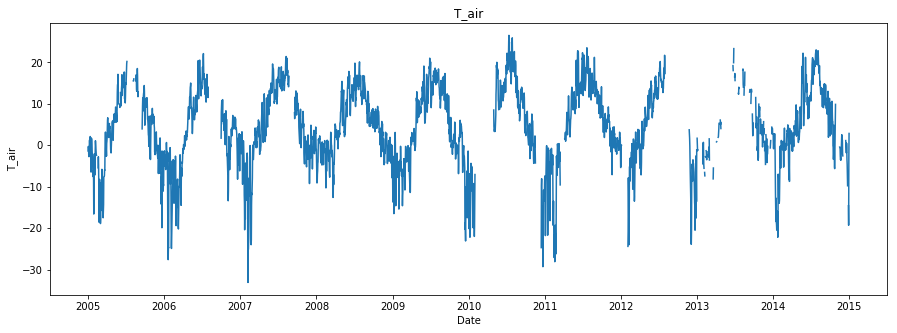

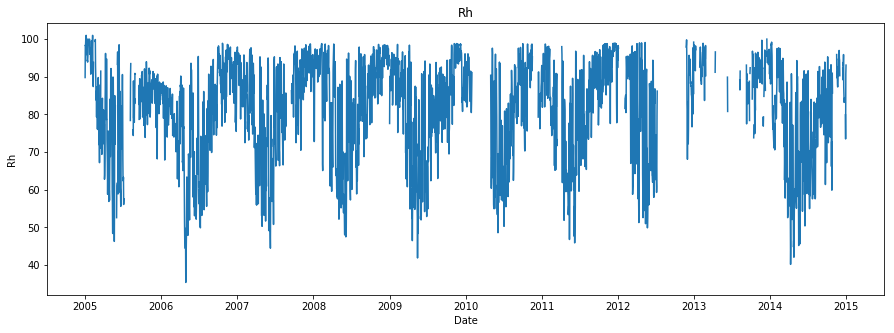

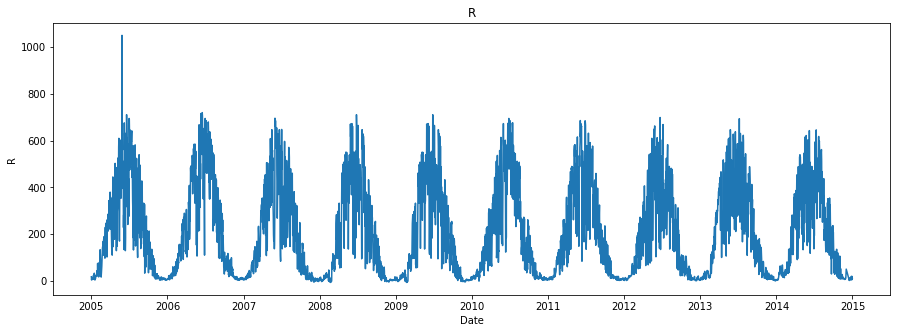

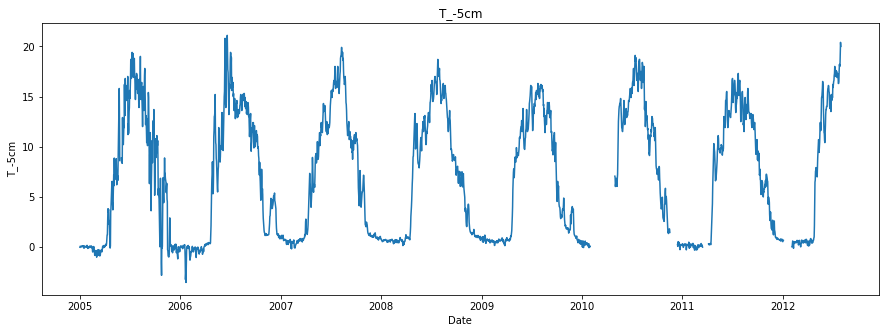

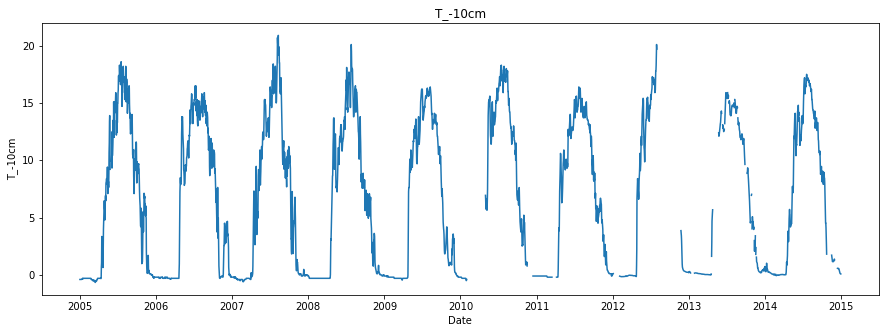

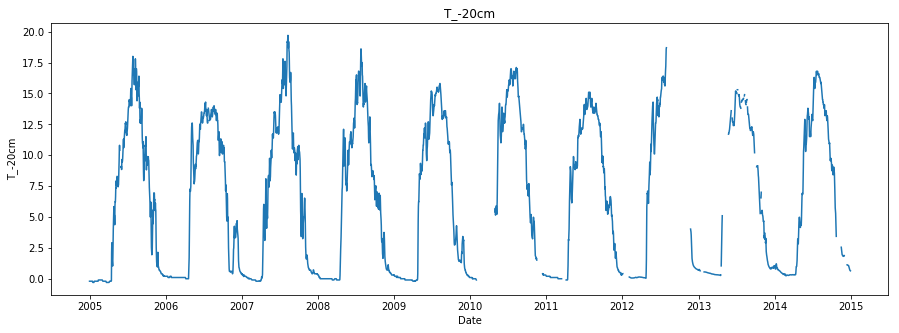

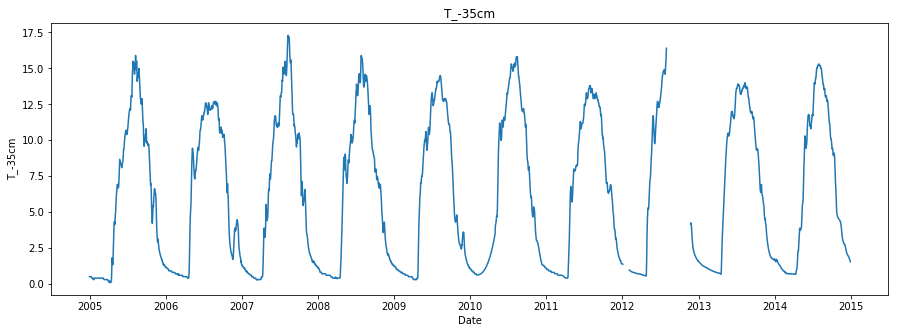

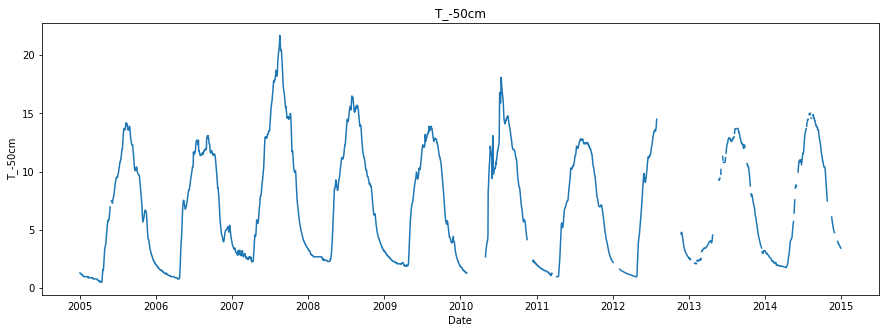

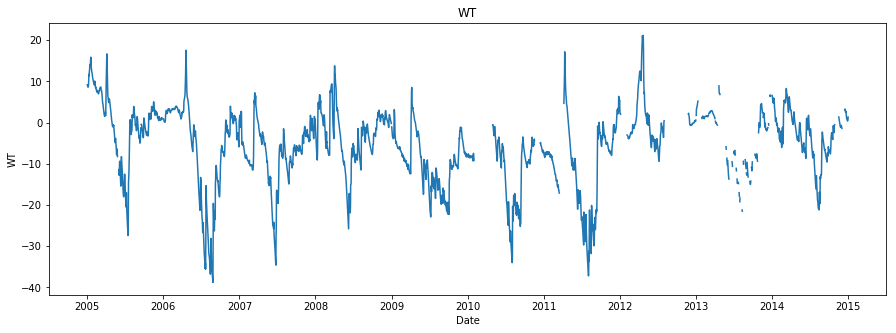

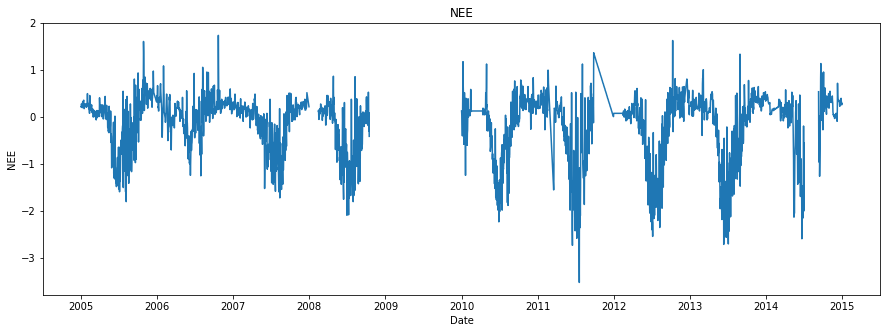

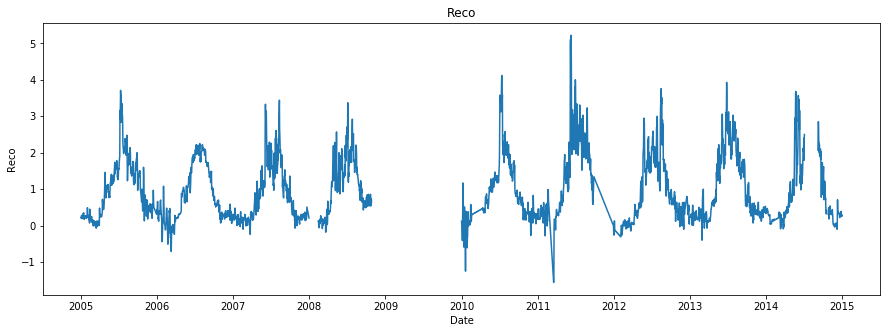

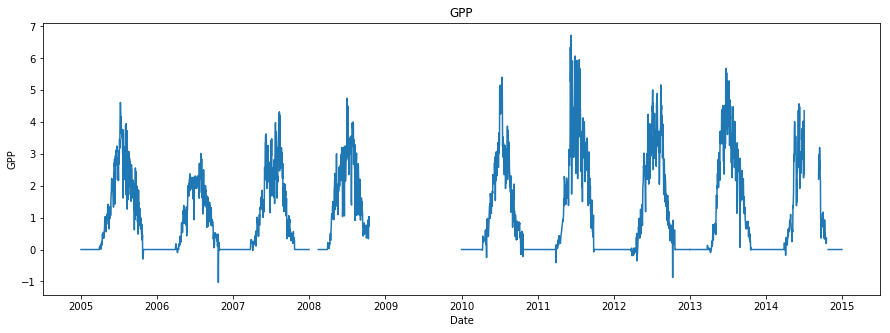

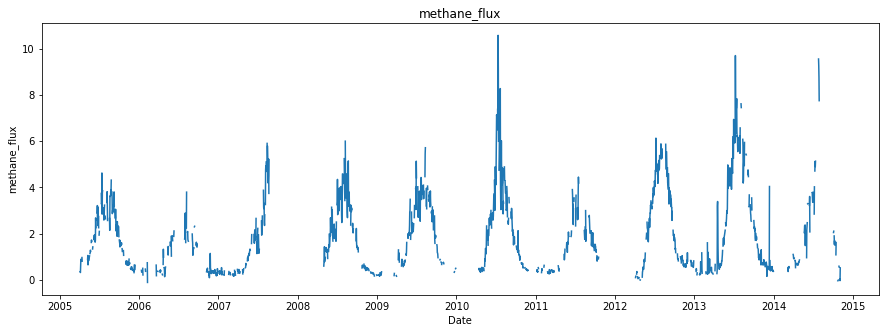

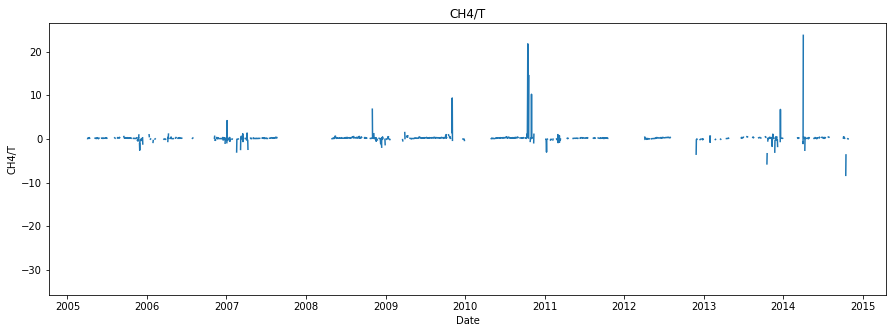

In [92]:
count = 0
for column in table:
    plt.figure(figsize=[15,5])
    plt.plot(table[column])
    plt.title(table.columns[count])
    plt.xlabel('Date')
    plt.ylabel(table.columns[count])
    count = count + 1

## Observations
 - Rh has a few values > 100
 - R has an outlier > 1000
 - NEE has a few periods that appear linearly gapfilled, rather than blanked out
 - GPP and R each have values < 0. 
 - Methane flux and CH4/T have some outliers, probably due to normalization by temperature when temperature is near 0. 

## Now address these problems:
### Relative humidity > 100

Text(0,0.5,'Rh')

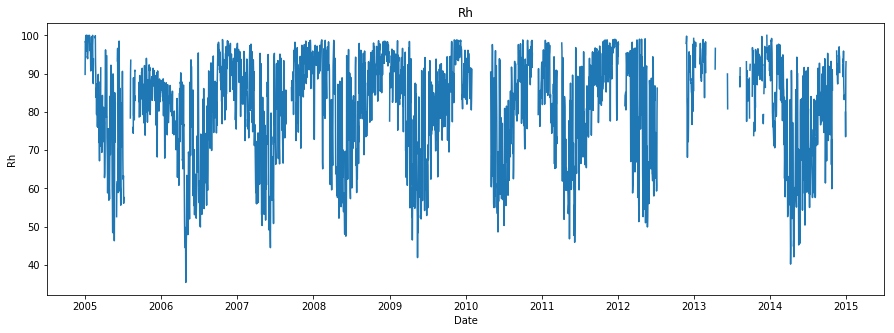

In [93]:
table.loc[table['Rh'] > 100, 'Rh'] = 100
plt.figure(figsize=[15,5])
plt.plot(table['Rh'])
plt.title('Rh')
plt.xlabel('Date')
plt.ylabel('Rh')

## R > 1000

Text(0,0.5,'R')

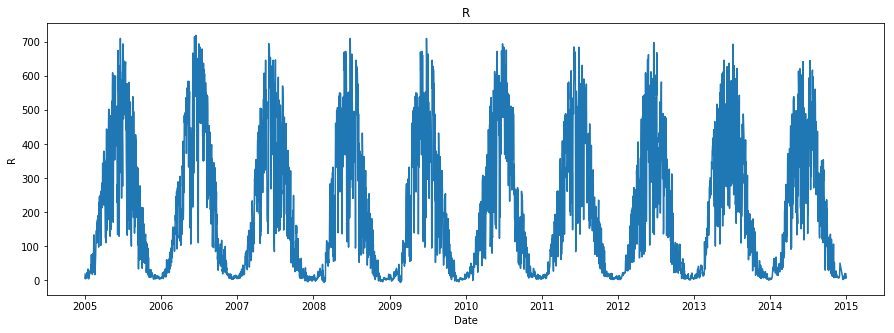

In [94]:
table.loc[table['R'] > 1000, 'R'] = np.nan
plt.figure(figsize=[15,5])
plt.plot(table['R'])
plt.title('R')
plt.xlabel('Date')
plt.ylabel('R')

## Problems with NEE, Reco, and GPP
First, produce an interactive plot to determine date ranges of problem areas.

<IPython.core.display.Javascript object>


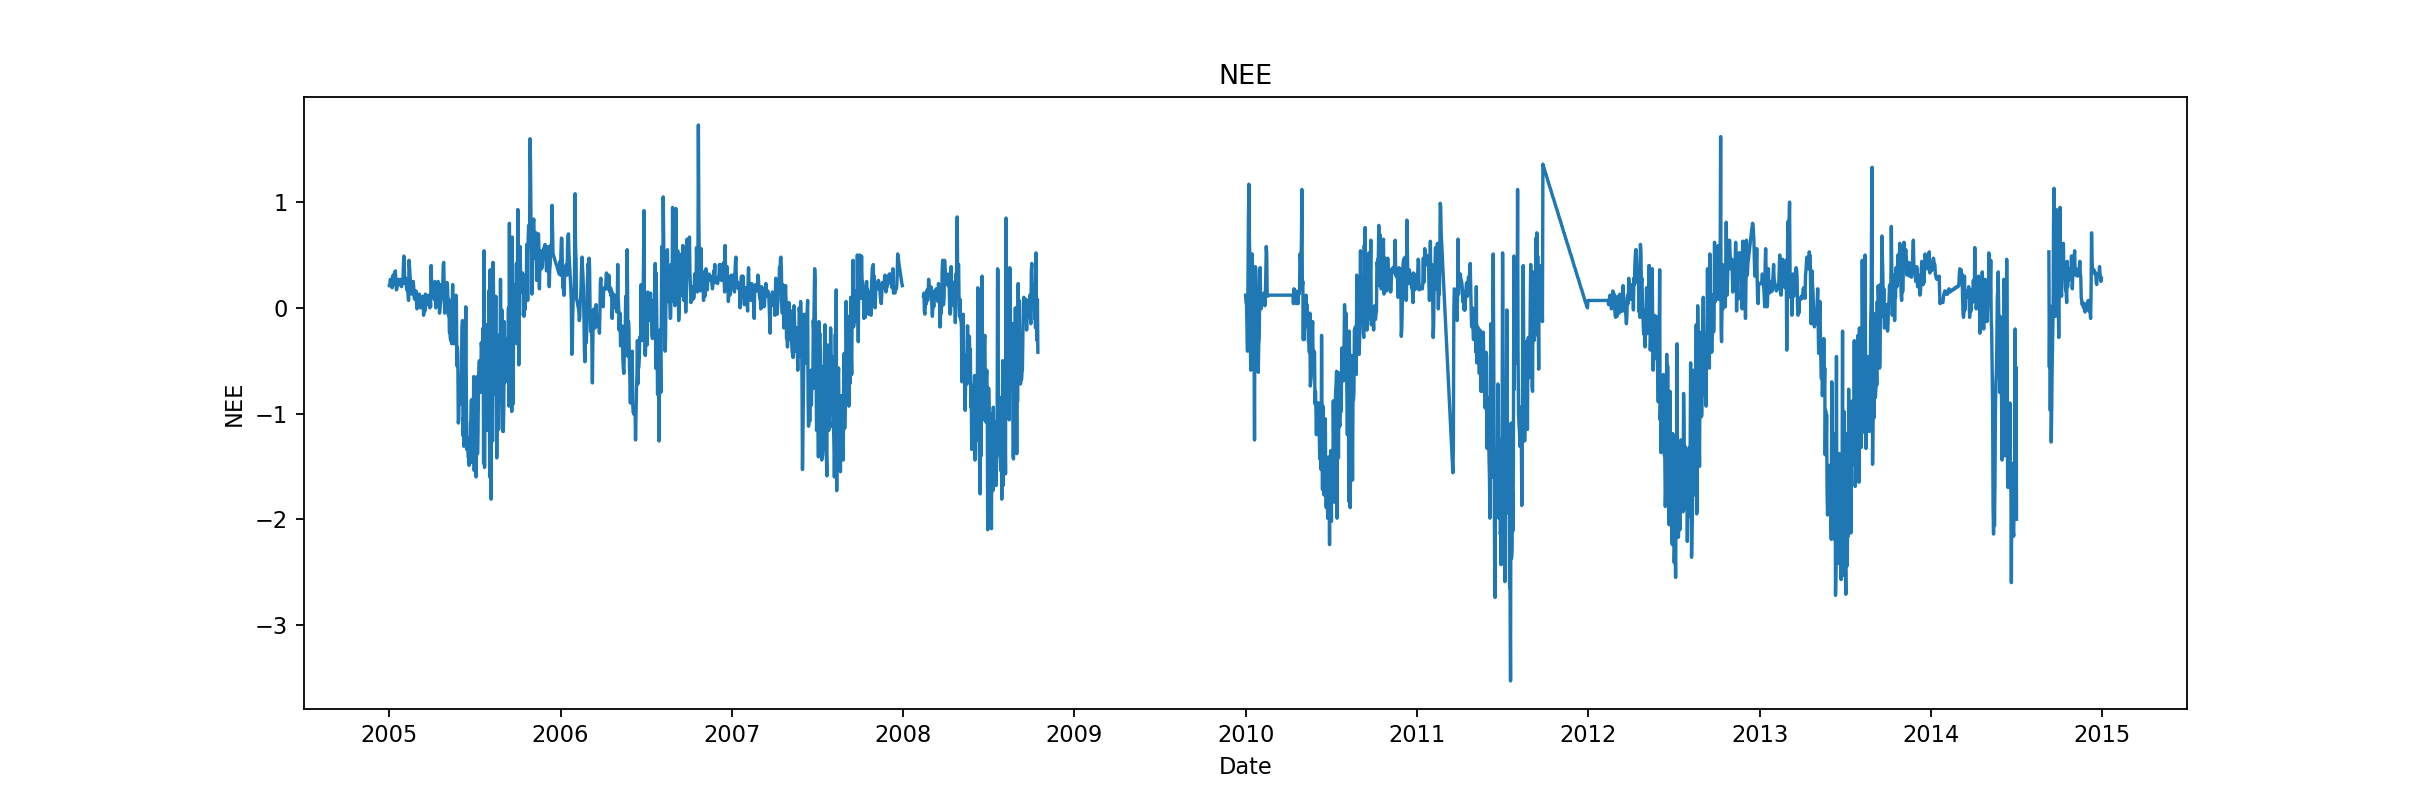

In [72]:
%matplotlib notebook
%matplotlib notebook # Repeating this is a hack to avoid restarting the kernel (since matplotlib inline has already been called)
plt.figure(figsize=[15,5])
plt.plot(table['NEE'])
plt.title('NEE')
plt.xlabel('Date')
plt.ylabel('NEE')
count = count + 1

### Problematic date ranges
"()" means the listed dates themselves are not included in the problem range; "[]" means they are. 

 - (2010-02-17, 2010-04-11)
 - [2011-09-26, 2012-02-03)
 - (2014-02-09, 2014-03-02)
 
The same ranges apply to Reco.
 
It appears that there is also a low-value outlier (<-3.5) in 2011. But for now I'm going to leave this in because I'm not convinced it is a mistake. 

Now, convert the above linearly interpolated regions to NaNs:

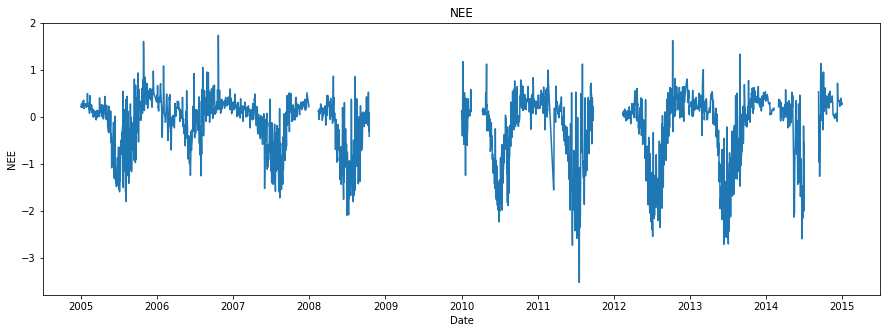

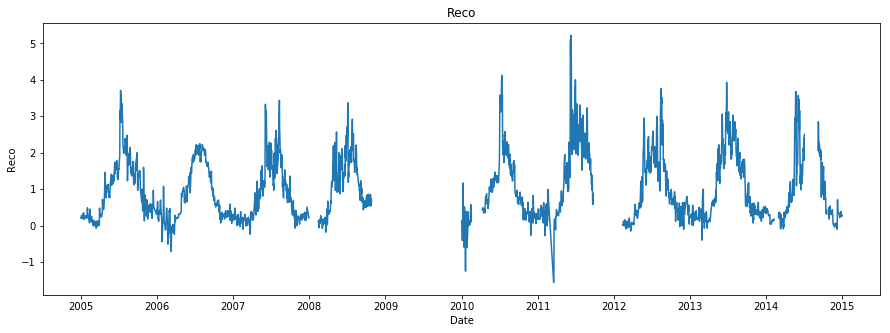

In [95]:
table.loc['2010-02-18':'2010-04-10', ['NEE', 'Reco']] = np.nan
table.loc['2011-09-26':'2012-02-12', ['NEE', 'Reco']] = np.nan
table.loc['2014-02-10':'2014-03-01', ['NEE', 'Reco']] = np.nan

%matplotlib inline
plt.figure(figsize=[15,5])
plt.plot(table['NEE'])
plt.title('NEE')
plt.xlabel('Date')
plt.ylabel('NEE')
count = count + 1

plt.figure(figsize=[15,5])
plt.plot(table['Reco'])
plt.title('Reco')
plt.xlabel('Date')
plt.ylabel('Reco')
count = count + 1

### GPP and R points < 0:

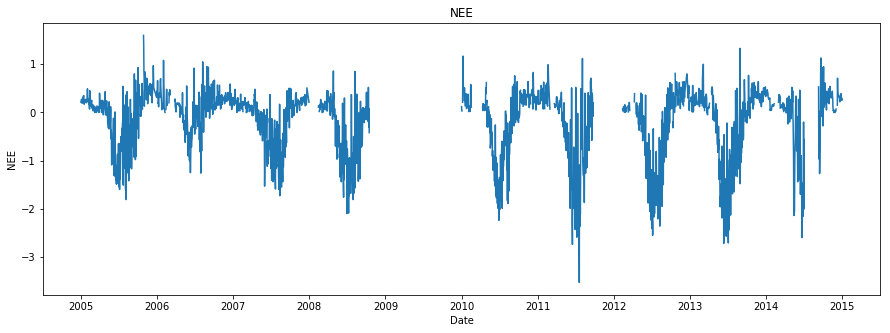

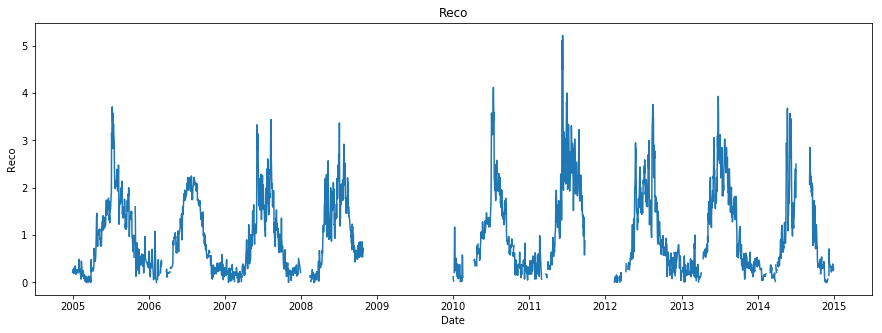

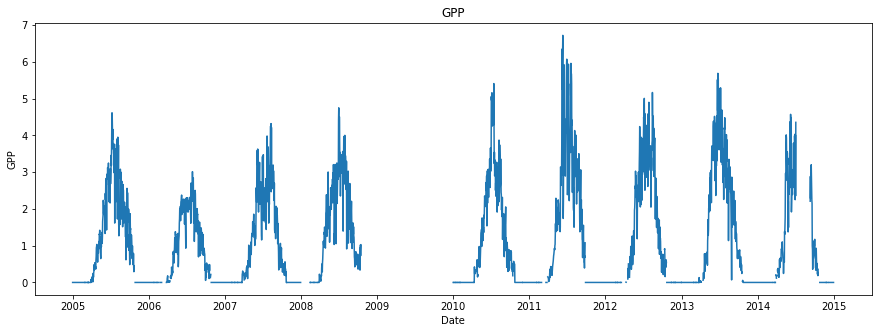

In [96]:
table.loc[(table.Reco < 0), ['Reco', 'NEE', 'GPP']] = np.nan
table.loc[(table.GPP < 0), ['Reco', 'NEE', 'GPP']] = np.nan
%matplotlib inline
plt.figure(figsize=[15,5])
plt.plot(table['NEE'])
plt.title('NEE')
plt.xlabel('Date')
plt.ylabel('NEE')
count = count + 1

plt.figure(figsize=[15,5])
plt.plot(table['Reco'])
plt.title('Reco')
plt.xlabel('Date')
plt.ylabel('Reco')
count = count + 1

plt.figure(figsize=[15,5])
plt.plot(table['GPP'])
plt.title('GPP')
plt.xlabel('Date')
plt.ylabel('GPP')
count = count + 1

## Plot histograms of data

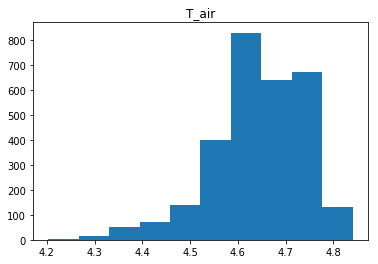

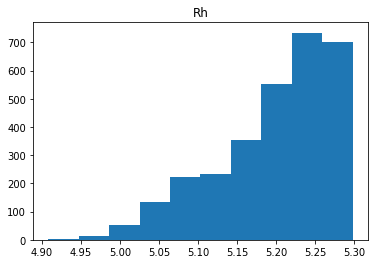

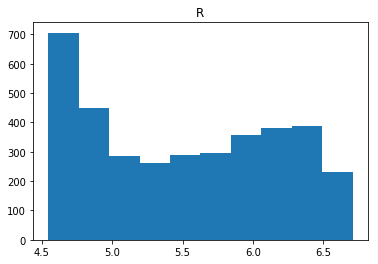

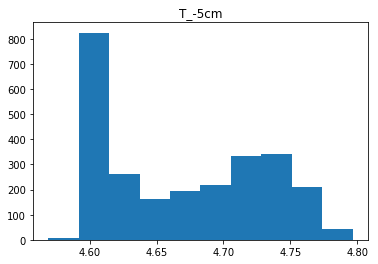

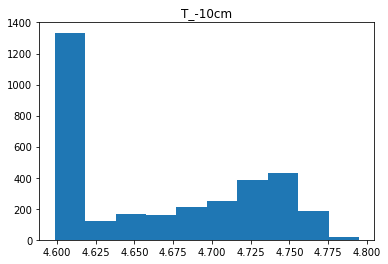

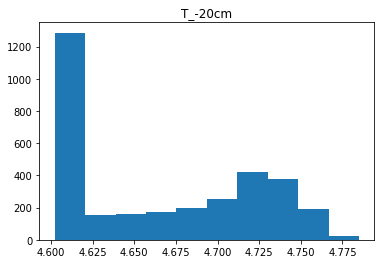

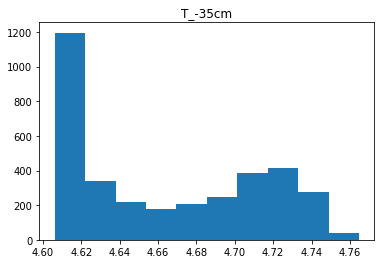

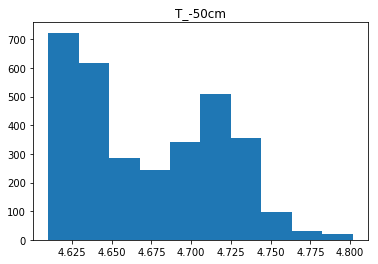

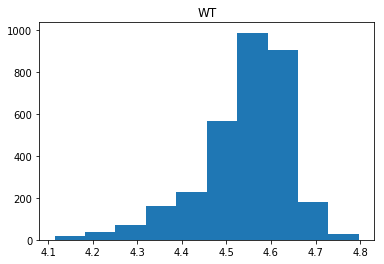

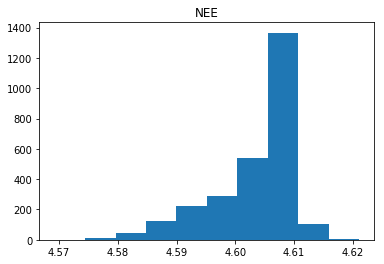

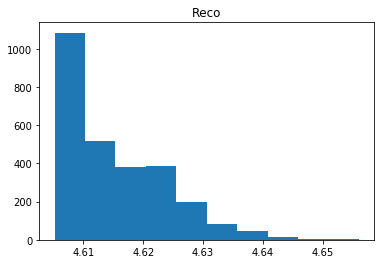

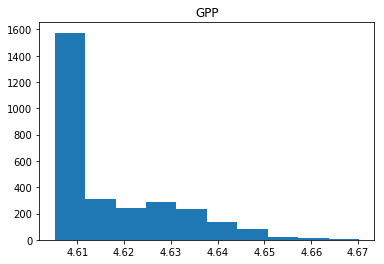

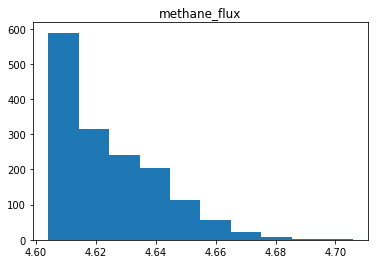

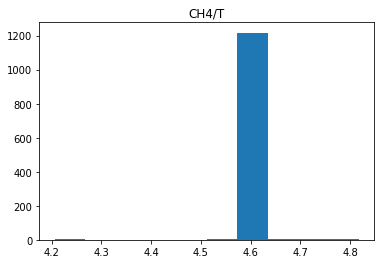

In [112]:
count = 0
for column in table:
    pylab.figure()
    pylab.hist((table.loc[~np.isnan(table[column]), column]))
    #pylab.show()
    pylab.title(table.columns[count])
    count = count + 1

#pylab.figure()
#pylab.hist(table.GPP[~np.isnan(table.GPP)])
#pylab.show()

In [101]:
np.min(table.GPP[~np.isnan(table.GPP)])

0.0

In [97]:
table.to_csv('Cleaned_Daily.csv', sep=',')

# Legacy; do not run anything below this

In [ ]:
# Name of hydro-meteorological stations
nameStrflwStation = np.array(['GSLOOK','GSWS01','GSWS02','GSWS03','GSWS06','GSWS07',
                              'GSWS08','GSWS09','GSWS10','GSWSMA','GSWSMC','GSWSMF'])
nameHydrMetStation = np.array(['CENMET','CS2MET','H15MET','PRIMET','UPLMET','VARMET','VANMET','WS7MET'])


In [5]:
nameTab = pd.Series(table.columns)
#nameTab[0].split('_')[0]
n_Tab = nameTab.apply(lambda x: x.split('_')[0])

In [6]:
pd.unique(n_Tab)

array(['GSLOOK', 'GSWS01', 'GSWS02', 'GSWS03', 'GSWS06', 'GSWS07',
       'GSWS08', 'GSWS09', 'GSWS10', 'GSWSMA', 'GSWSMC', 'GSWSMF',
       'CENMET', 'CS2MET', 'H15MET', 'PRIMET', 'UPLMET', 'VANMET',
       'VARMET'], dtype=object)

In [7]:
# Pool out a single meteorological station data
table2 = copy.deepcopy(table)
stn_met = 'PRIMET'
stn_flow = 'GSLOOK'
for i in np.arange(len(table.columns)):
    if nameTab[i].split('_')[0]!=stn_met and nameTab[i].split('_')[0]!=stn_flow:
        table2 = table2.drop(columns=table.columns[i],axis=1)
        
#table2['GSLOOK_discharge'] = table.GSLOOK_discharge

# End of legacy block

In [31]:
table2 = copy.deepcopy(table) #Needed only so that I don't have to change variable names in the legacy code.
table2.columns

Index(['T_air', 'Rh', 'R', 'T_-5cm', 'T_-10cm', 'T_-20cm', 'T_-35cm',
       'T_-50cm', 'WT', 'NEE', 'Reco', 'GPP', 'methane_flux', 'CH4/T'],
      dtype='object')

In [9]:
# Identify the first non nan value in each column as a starting date.
# This can be modified based on the data length and variable type. (e.g. wind speed should not dictate data length)
# Dropping long years of data is costly.

t = table2.notna() #
t = ~np.isnan(table2)
col = len(t.columns)
b = np.zeros([table2.shape[1]])

for i in range(col):
    #print(i)
    if any(t.iloc[:,i]): # Since some are empty
        b[i] = list(np.where(t.iloc[:,i] == True))[0][0] # the first non nan value location

        


st_tab = b.max() 
int(st_tab)
table3 = table2.iloc[int(st_tab):,:] # st_tab years of data is cut out due to radiation
table3.head(5)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2001-02-21              51.0                 5.4                 5.8   
2001-02-22              53.0                 3.5                 3.9   
2001-02-23              53.0                 3.5                 3.8   
2001-02-24              52.0                 3.0                 3.3   
2001-02-25              49.0                 3.2                 3.5   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_130_AirTemp  \
DateTime                                                                 
2001-02-21                 5.6                 5.6                 NaN   
2001-02-22                 3.7                 3.7                 NaN   
2001-02-23                 3.6                 3.7                 NaN   
2001-02-24                 3.1                 3.1                 NaN   
2001-02-25                 3.3                 3.2                 NaN   

            PRIMET_480_AirTemp  PRIMET_50_AirTemp  PRIMET_450_humidity  \
DateTime                                                                 
2001-02-21                 NaN                NaN                 98.5   
2001-02-22                 NaN                NaN                 97.1   
2001-02-23                 NaN                NaN                 96.9   
2001-02-24                 NaN                NaN                 95.9   
2001-02-25                 NaN                NaN                 92.6   

            PRIMET_150_humidity       ...        PRIMET_150_vaporPDeficit  \
DateTime                              ...                                   
2001-02-21                 98.2       ...                             0.2   
2001-02-22                 97.2       ...                             0.3   
2001-02-23                 96.9       ...                             0.3   
2001-02-24                 96.1       ...                             0.4   
2001-02-25                 93.2       ...                             1.0   

            PRIMET_10_ST  PRIMET_20_ST  PRIMET_50_ST  PRIMET_100_ST  \
DateTime                                                              
2001-02-21           5.3           4.9           5.0            5.8   
2001-02-22           5.6           5.2           5.3            5.9   
2001-02-23           6.0           5.6           5.5            6.0   
2001-02-24           5.9           5.6           5.7            6.1   
2001-02-25           5.9           5.7           5.8            6.1   

            PRIMET_30_ST  PRIMET_10_VMC  PRIMET_20_VMC  PRIMET_50_VMC  \
DateTime                                                                
2001-02-21           NaN           0.26           0.21           0.22   
2001-02-22           NaN           0.25           0.21           0.22   
2001-02-23           NaN           0.25           0.20           0.22   
2001-02-24           NaN           0.24           0.20           0.21   
2001-02-25           NaN           0.23           0.19           0.21   

            PRIMET_100_VMC  
DateTime                    
2001-02-21            0.25  
2001-02-22            0.27  
2001-02-23            0.27  
2001-02-24            0.27  
2001-02-25            0.26  

[5 rows x 44 columns]

In [10]:
b

array([  273., 16692., 16692., 16692.,  8530.,     0.,     0.,     0.,
       19044., 14432.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0., 11021.,     0.,     0.,     0.,  8530., 11020.,
           0.,     0.,     0., 19044., 11021.,     0.,  8530., 19044.,
       14432., 19044., 14432., 16692., 14432., 16692., 16692.,     0.,
       18052., 18052., 18052., 18052.])

In [11]:
# droping columns without data
tt = copy.deepcopy(table3)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print(dd,tt.columns[dd])
        table3 = table3.drop(columns = tt.columns[dd],axis=1)

table3.head(5)

5 PRIMET_130_AirTemp
6 PRIMET_480_AirTemp
7 PRIMET_50_AirTemp
10 PRIMET_130_humidity
11 PRIMET_480_humidity
12 PRIMET_455_precip
13 PRIMET_625_precip
14 PRIMET_260_precip
15 PRIMET_250_precip
16 PRIMET_550_precip
17 PRIMET_410_precip
19 PRIMET_450_precip
20 PRIMET_305_precip
21 PRIMET_625_solar
22 PRIMET_500_solar
24 PRIMET_615_solar
25 PRIMET_450_solar
26 PRIMET_850_solar
29 PRIMET_480_dewPointT
30 PRIMET_100_dewPointT
39 PRIMET_30_ST


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2001-02-21              51.0                 5.4                 5.8   
2001-02-22              53.0                 3.5                 3.9   
2001-02-23              53.0                 3.5                 3.8   
2001-02-24              52.0                 3.0                 3.3   
2001-02-25              49.0                 3.2                 3.5   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2001-02-21                 5.6                 5.6                 98.5   
2001-02-22                 3.7                 3.7                 97.1   
2001-02-23                 3.6                 3.7                 96.9   
2001-02-24                 3.1                 3.1                 95.9   
2001-02-25                 3.3                 3.2                 92.6   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2001-02-21                 98.2                8.4              62.0   
2001-02-22                 97.2                3.3              49.0   
2001-02-23                 96.9                2.8              59.0   
2001-02-24                 96.1                0.0             106.0   
2001-02-25                 93.2                0.0             118.0   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2001-02-21                   5.2       ...                             0.2   
2001-02-22                   3.1       ...                             0.3   
2001-02-23                   3.0       ...                             0.3   
2001-02-24                   2.3       ...                             0.5   
2001-02-25                   1.9       ...                             1.0   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2001-02-21                       0.2           5.3           4.9   
2001-02-22                       0.3           5.6           5.2   
2001-02-23                       0.3           6.0           5.6   
2001-02-24                       0.4           5.9           5.6   
2001-02-25                       1.0           5.9           5.7   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2001-02-21           5.0            5.8           0.26           0.21   
2001-02-22           5.3            5.9           0.25           0.21   
2001-02-23           5.5            6.0           0.25           0.20   
2001-02-24           5.7            6.1           0.24           0.20   
2001-02-25           5.8            6.1           0.23           0.19   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2001-02-21           0.22            0.25  
2001-02-22           0.22            0.27  
2001-02-23           0.22            0.27  
2001-02-24           0.21            0.27  
2001-02-25           0.21            0.26  

[5 rows x 23 columns]

### Streamflow
1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.

In [12]:
# Set a new Table for final cleaned daily data
TableFinal = copy.deepcopy(table3)
TableFinal.iloc[:][:] = np.nan
TableFinal.iloc[1:3,:]

GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2001-02-22               NaN                 NaN                 NaN   
2001-02-23               NaN                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2001-02-22                 NaN                 NaN                  NaN   
2001-02-23                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2001-02-22                  NaN                NaN               NaN   
2001-02-23                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2001-02-22                   NaN       ...                             NaN   
2001-02-23                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2001-02-22                       NaN           NaN           NaN   
2001-02-23                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2001-02-22           NaN            NaN            NaN            NaN   
2001-02-23           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2001-02-22            NaN             NaN  
2001-02-23            NaN             NaN  

[2 rows x 23 columns]

In [13]:
i = 0 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    51.0
2001-02-22    53.0
2001-02-23    53.0
2001-02-24    52.0
2001-02-25    49.0
Name: GSLOOK_discharge, dtype: float64

There are missing data.


array([], shape=(0, 1), dtype=int64)

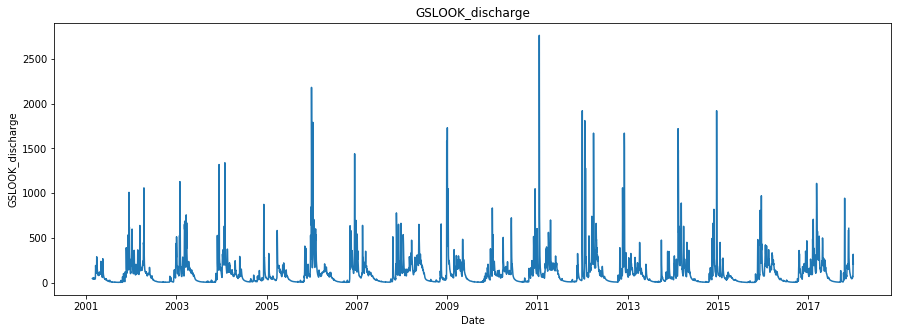

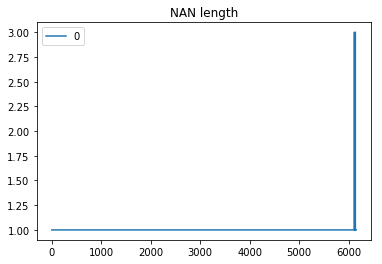

In [14]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))
pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 
np.argwhere(table3[VarName]<0) # negative non negative

total length = (6158,)
remainingNan length = Empty DataFrame
Columns: [0]
Index: []


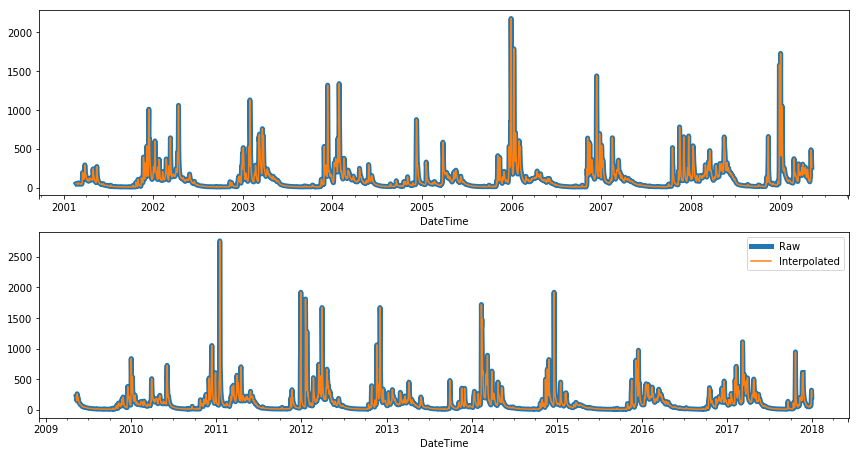

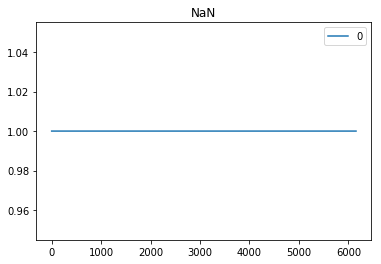

In [15]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
print('remainingNan length =',remainingNAN)


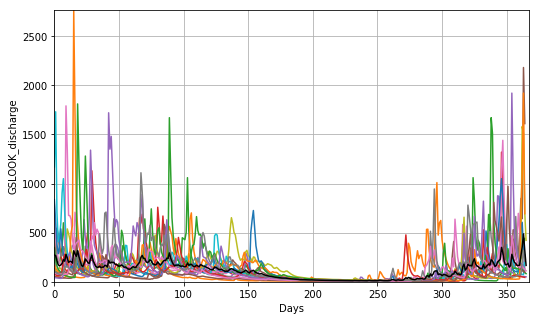

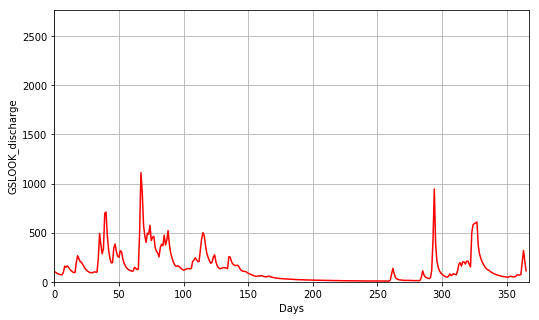

In [16]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 365 days and additional two columns for a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan or with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                #print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]])# Filled with the mean value.                    
        #print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2001-02-21              51.0                 NaN                 NaN   
2001-02-22              53.0                 NaN                 NaN   
2001-02-23              53.0                 NaN                 NaN   
2001-02-24              52.0                 NaN                 NaN   
2001-02-25              49.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2001-02-21                 NaN                 NaN                  NaN   
2001-02-22                 NaN                 NaN                  NaN   
2001-02-23                 NaN                 NaN                  NaN   
2001-02-24                 NaN                 NaN                  NaN   
2001-02-25                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2001-02-21                  NaN                NaN               NaN   
2001-02-22                  NaN                NaN               NaN   
2001-02-23                  NaN                NaN               NaN   
2001-02-24                  NaN                NaN               NaN   
2001-02-25                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2001-02-21                   NaN       ...                             NaN   
2001-02-22                   NaN       ...                             NaN   
2001-02-23                   NaN       ...                             NaN   
2001-02-24                   NaN       ...                             NaN   
2001-02-25                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2001-02-21                       NaN           NaN           NaN   
2001-02-22                       NaN           NaN           NaN   
2001-02-23                       NaN           NaN           NaN   
2001-02-24                       NaN           NaN           NaN   
2001-02-25                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2001-02-21           NaN            NaN            NaN            NaN   
2001-02-22           NaN            NaN            NaN            NaN   
2001-02-23           NaN            NaN            NaN            NaN   
2001-02-24           NaN            NaN            NaN            NaN   
2001-02-25           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2001-02-21            NaN             NaN  
2001-02-22            NaN             NaN  
2001-02-23            NaN             NaN  
2001-02-24            NaN             NaN  
2001-02-25            NaN             NaN  

[5 rows x 23 columns]

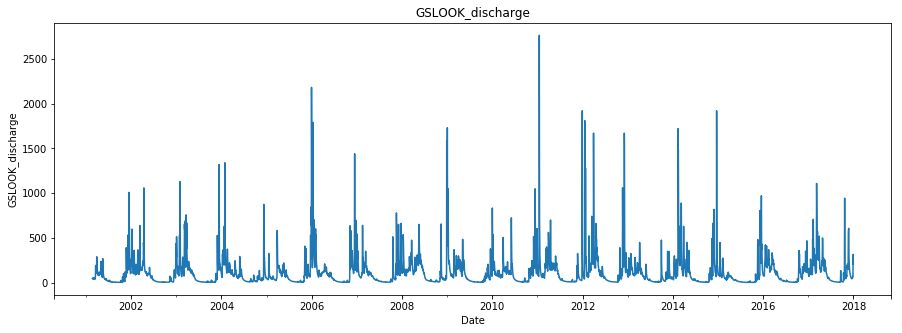

In [17]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.head(5)

In [18]:
# step 5/5
# ====================================================================
# Regression against a relevant predictor variable or another station.

### Temperature
1. Is there any negative number below -20c?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold2

In [19]:
i = 1 # 4 column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    5.4
2001-02-22    3.5
2001-02-23    3.5
2001-02-24    3.0
2001-02-25    3.2
Name: PRIMET_450_AirTemp, dtype: float64

There are missing data.
Outliers @


array([], shape=(0, 1), dtype=int64)

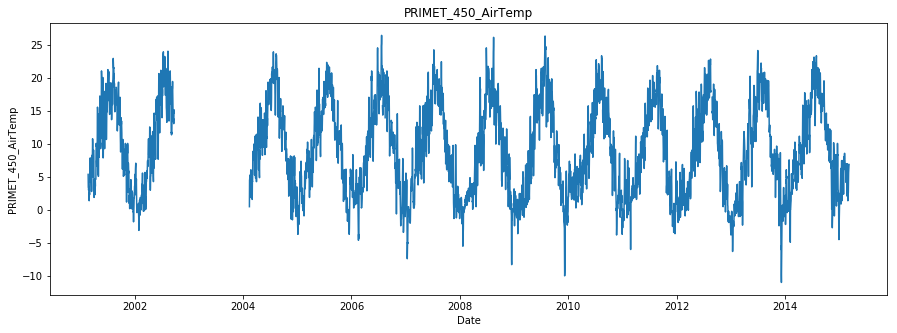

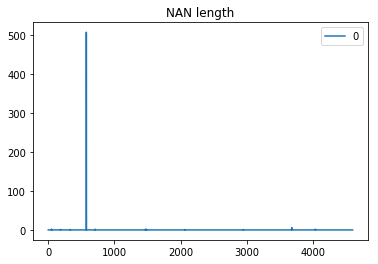

In [20]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 
print('Outliers @')
np.argwhere(table3[VarName]<-20) # negative non negative

total length = (6158,)


0
587  493

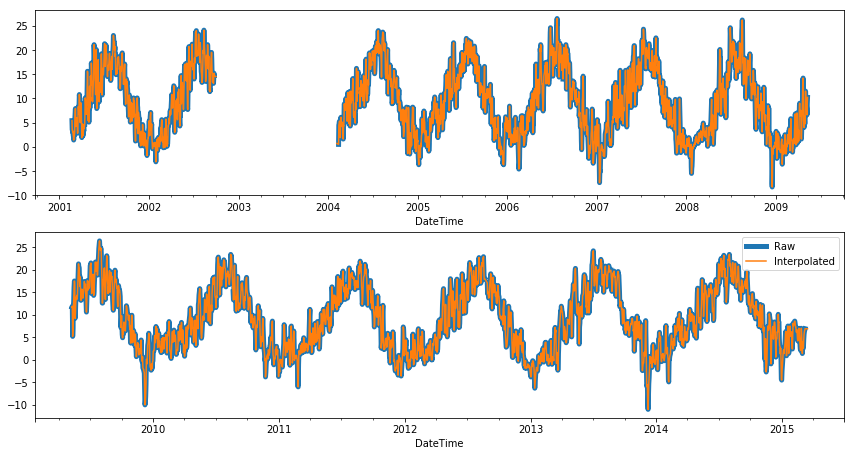

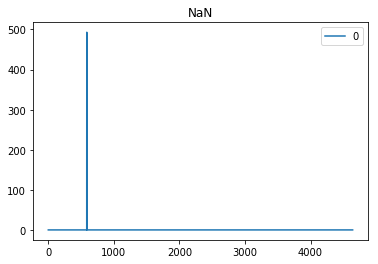

In [21]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) #Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

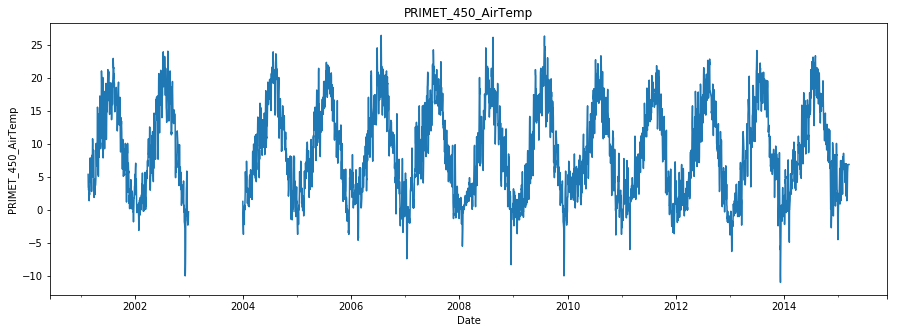

In [23]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

In [24]:
# step 5/5
# ====================================================================
# Regression against a relevant predictor variable or another station.

### Temperature
1. Is there any negative number below -20c?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold2

In [25]:
i = 2 # 4 column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    5.8
2001-02-22    3.9
2001-02-23    3.8
2001-02-24    3.3
2001-02-25    3.5
Name: PRIMET_350_AirTemp, dtype: float64

There are missing data.
Outliers @


array([], shape=(0, 1), dtype=int64)

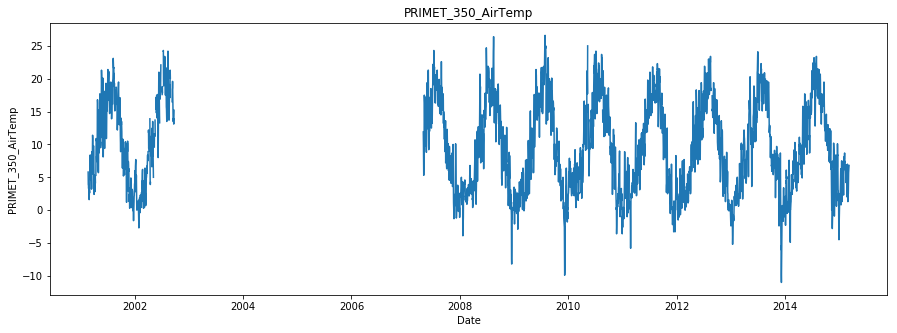

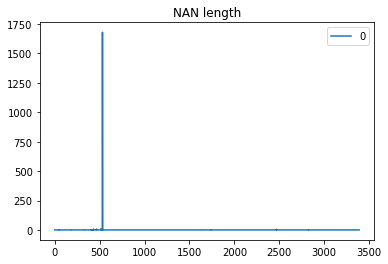

In [26]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 
print('Outliers @')
np.argwhere(table3[VarName]<-20) # negative non negative

total length = (6158,)


0
586  1666

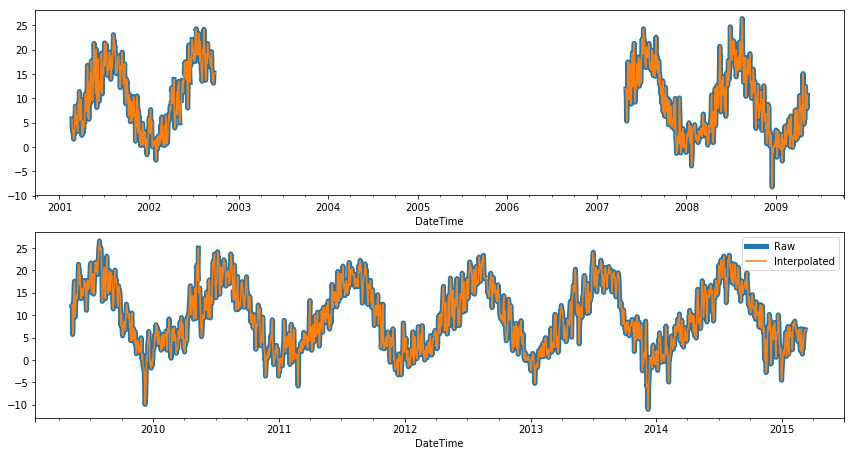

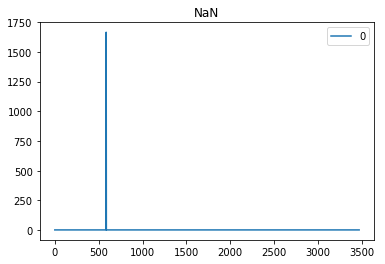

In [27]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


In [29]:
#all(np.isnan(table3.PRIMET_350_AirTemp.loc[table3.index.year==2002]))
#plt.plot(table3.PRIMET_350_AirTemp.loc[table3.index.year==2006])

GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

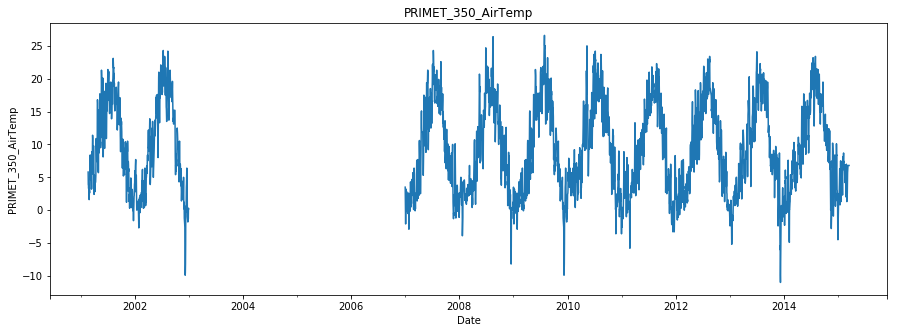

In [30]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### Temperature
1. Is there any negative number below -20c?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold2

In [31]:
i = 3 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    5.6
2001-02-22    3.7
2001-02-23    3.6
2001-02-24    3.1
2001-02-25    3.3
Name: PRIMET_250_AirTemp, dtype: float64

There are missing data.
Outliers @


array([], shape=(0, 1), dtype=int64)

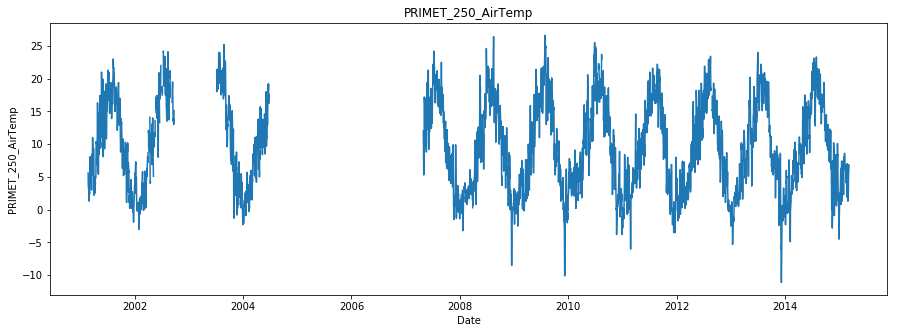

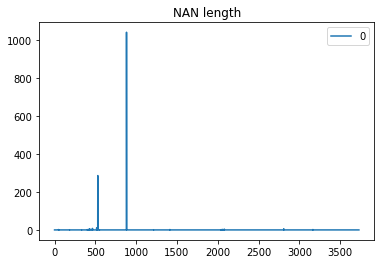

In [32]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 
print('Outliers @')
np.argwhere(table3[VarName]<-20) # negative non negative

total length = (6158,)


0
586   273
953  1027

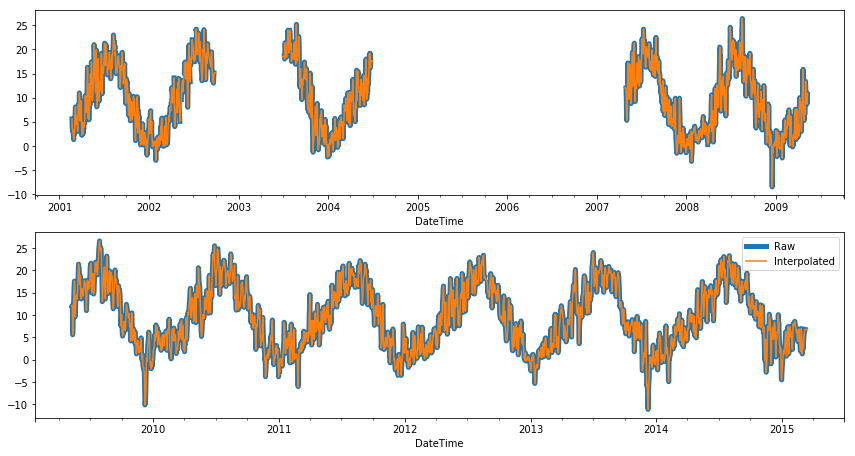

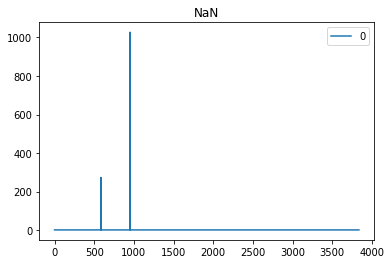

In [33]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

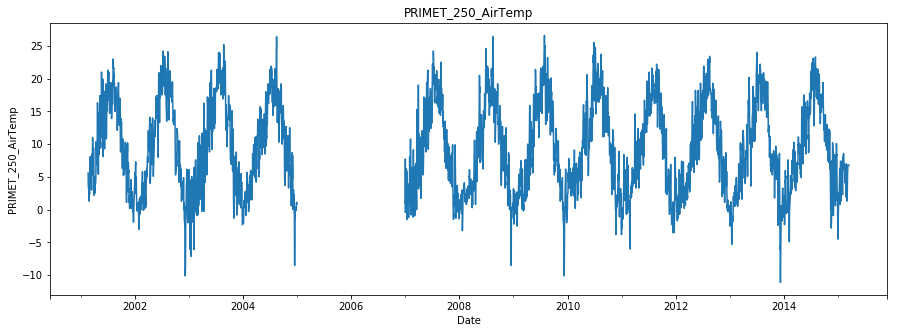

In [35]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

In [36]:
# step 5/5
# ====================================================================
# Regression against a relevant predictor variable or another station.

### Temperature
1. Is there any negative number below -20c?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold2

In [37]:
i = 4 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    5.6
2001-02-22    3.7
2001-02-23    3.7
2001-02-24    3.1
2001-02-25    3.2
Name: PRIMET_150_AirTemp, dtype: float64

There are missing data.
Outliers @


array([], shape=(0, 1), dtype=int64)

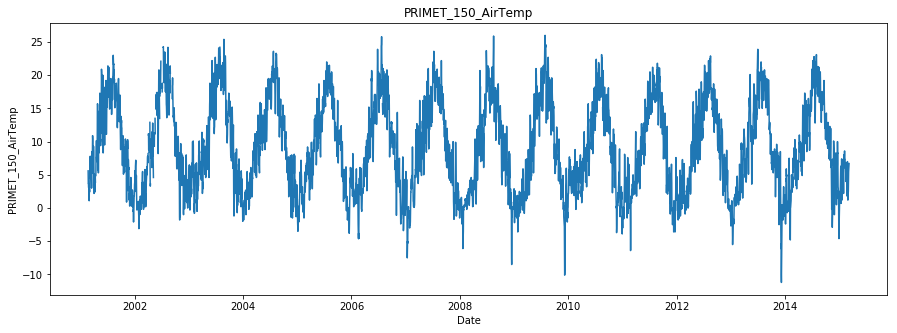

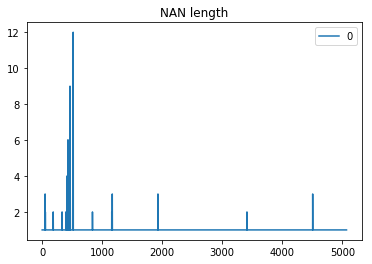

In [38]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 
print('Outliers @')
np.argwhere(table3[VarName]<-20) # negative non negative

total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

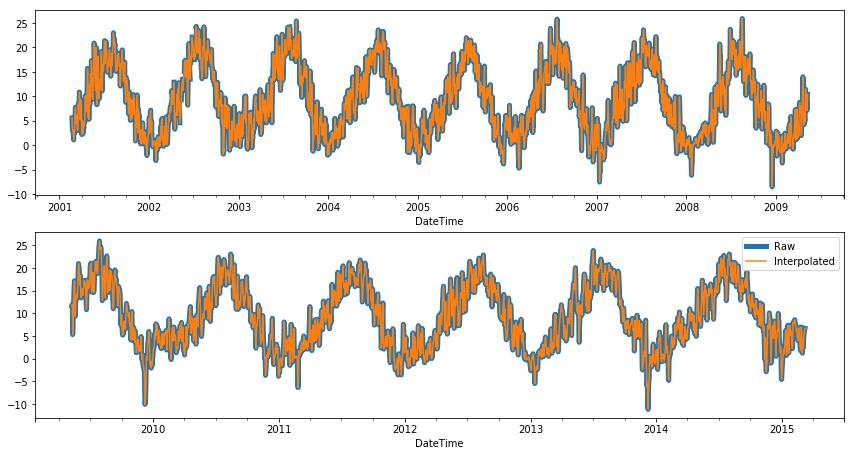

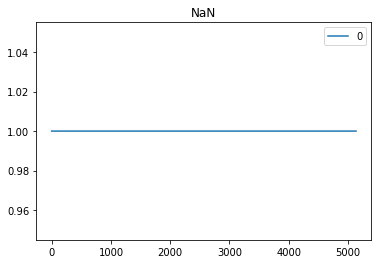

In [39]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

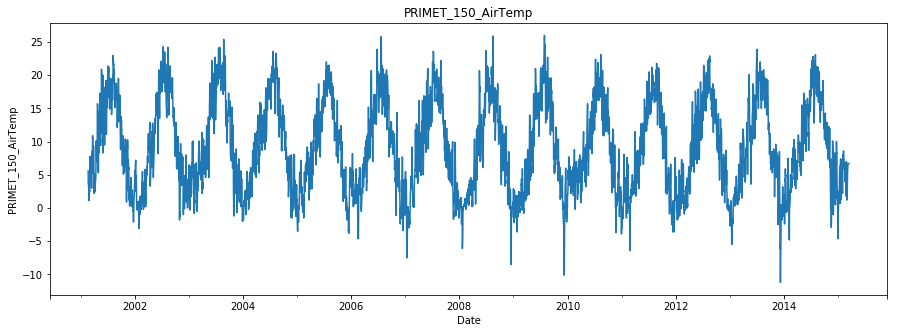

In [41]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

In [42]:
# step 5/5
# ====================================================================
# Regression against a relevant predictor variable or another station.

### RelativeHumidity

1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold2

In [43]:
i = 5 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    98.5
2001-02-22    97.1
2001-02-23    96.9
2001-02-24    95.9
2001-02-25    92.6
Name: PRIMET_450_humidity, dtype: float64

There are missing data.


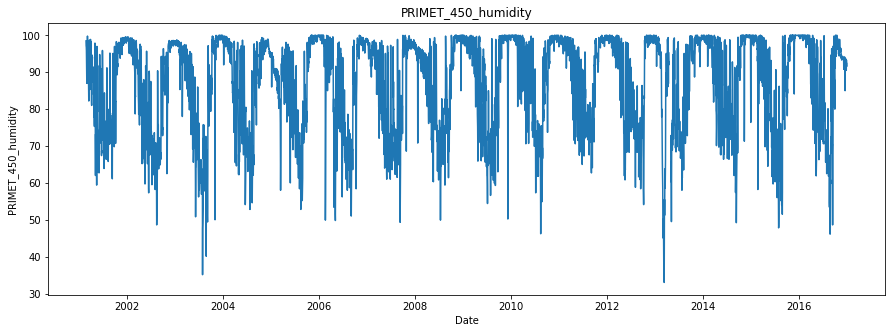

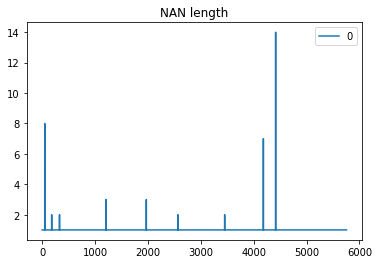

In [44]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 100)):
     print('There are outliers > 100')


total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

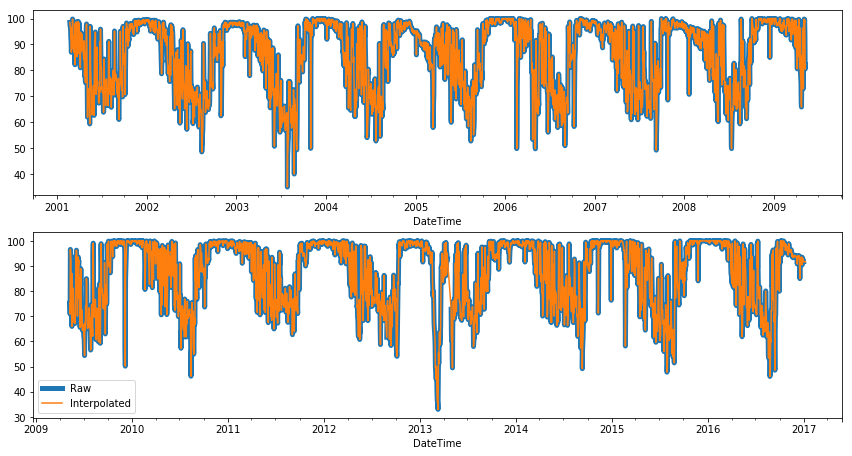

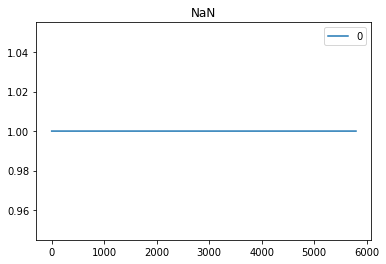

In [45]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

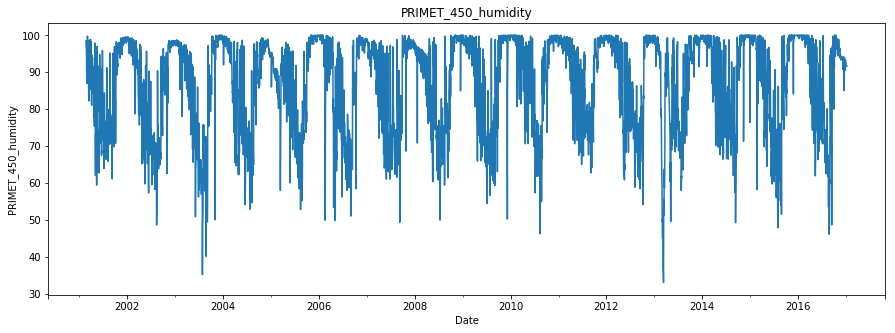

In [47]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

In [48]:
# step 5/5
# ====================================================================
# Regression against a relevant predictor variable or another station.

In [49]:
i = 6 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    98.2
2001-02-22    97.2
2001-02-23    96.9
2001-02-24    96.1
2001-02-25    93.2
Name: PRIMET_150_humidity, dtype: float64

There are missing data.


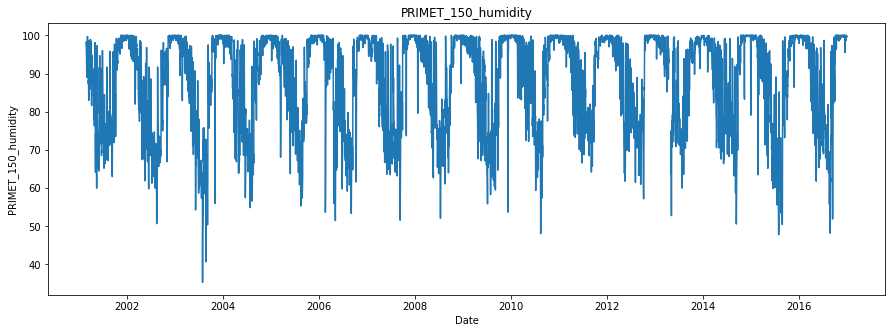

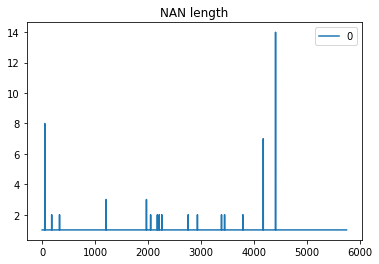

In [50]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 100)):
     print('There are outliers > 100')


total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

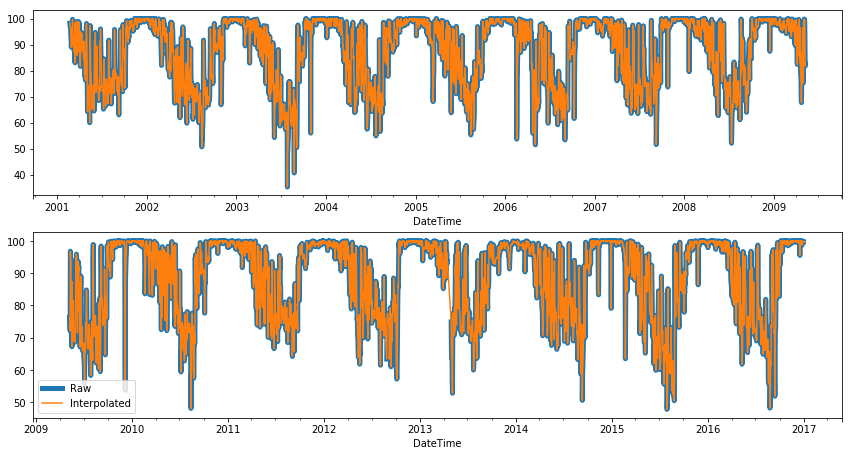

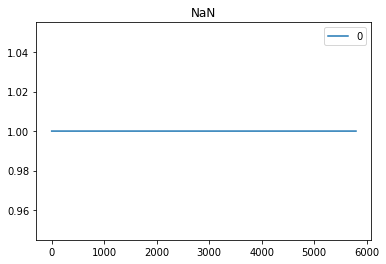

In [51]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]])# Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

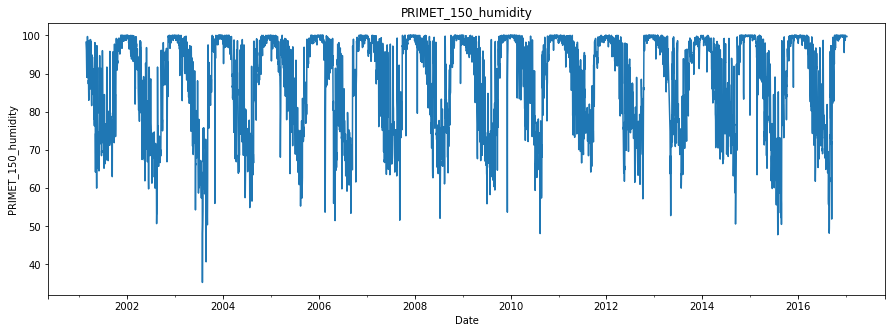

In [53]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

In [54]:
# step 5/5
# ====================================================================
# Regression against a relevant predictor variable or another station.

### Precipitation

1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.

In [55]:
i = 7 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    8.4
2001-02-22    3.3
2001-02-23    2.8
2001-02-24    0.0
2001-02-25    0.0
Name: PRIMET_100_precip, dtype: float64

There are missing data.


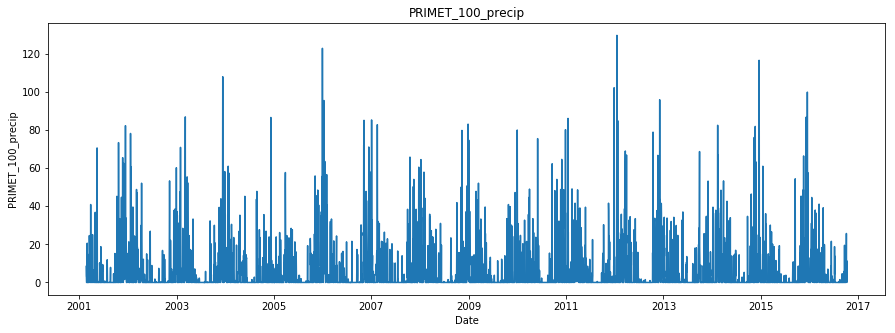

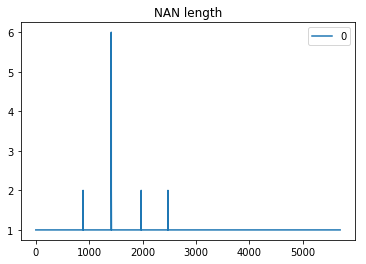

In [56]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
# if any(np.argwhere(table3[VarName] > 100)):
#      print('There are outliers > 100')


total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

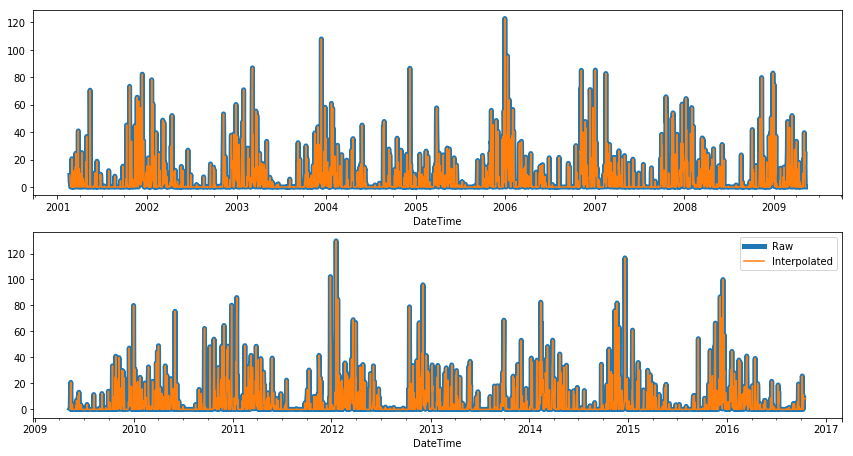

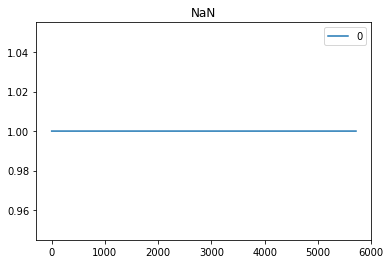

In [57]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

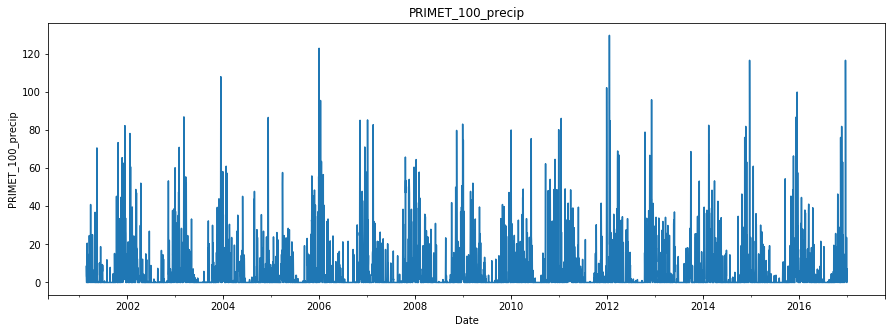

In [59]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

In [60]:
# step 5/5
# ====================================================================
# Regression against a relevant predictor variable or another station.

### SolarRadiation_Watts_m2
#### Day and Night time dynamics, hence interpolation is limited to 12hrs.
1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold2

In [61]:
i = 8 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21     62.0
2001-02-22     49.0
2001-02-23     59.0
2001-02-24    106.0
2001-02-25    118.0
Name: PRIMET_100_solar, dtype: float64

There are missing data.


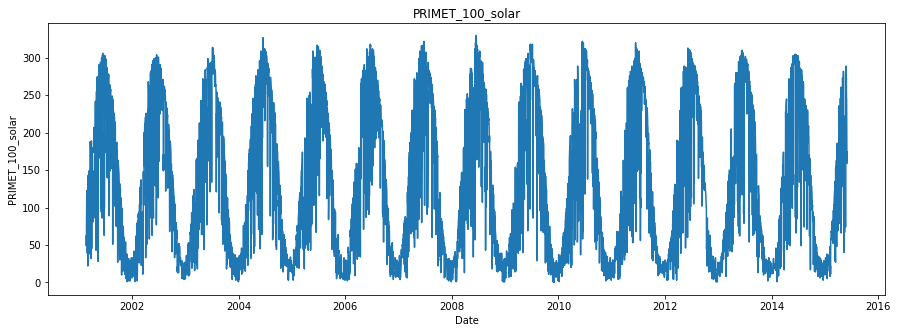

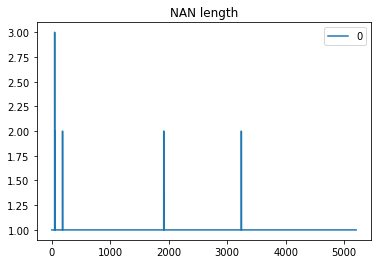

In [62]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
# if any(np.argwhere(table3[VarName] > 100)):
#      print('There are outliers > 100')


total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

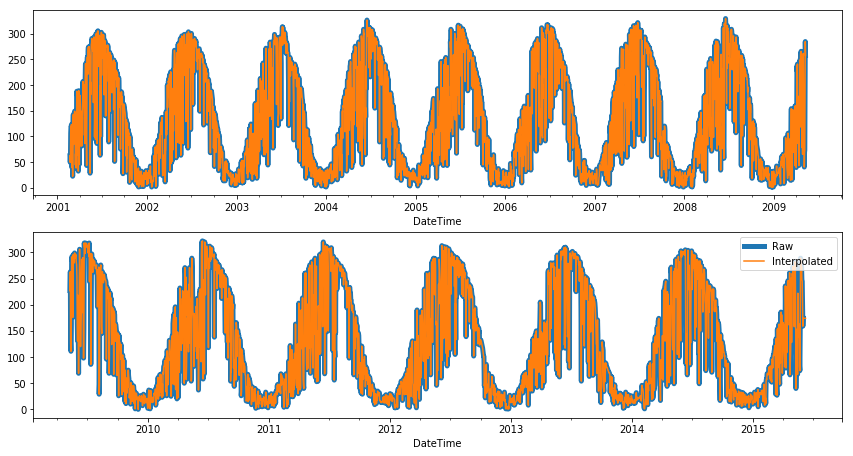

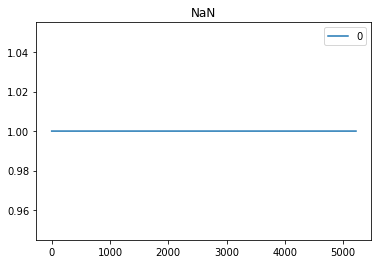

In [63]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

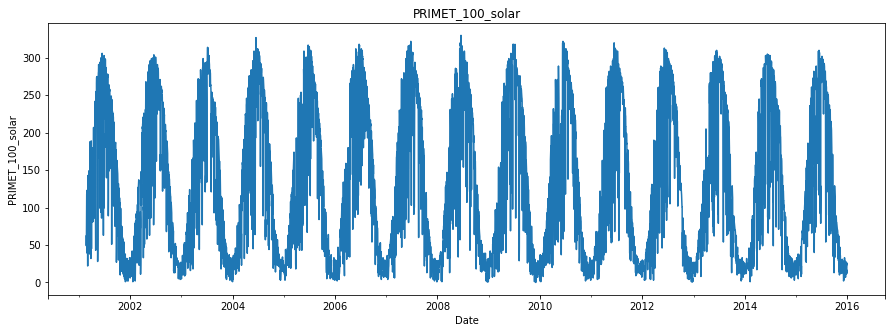

In [65]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

In [66]:
# step 5/5
# ====================================================================
# Regression against a relevant predictor variable or another station.

### SolarRadiation_Watts_m2
#### Day and Night time dynamics, hence interpolation is limited to 12hrs.
1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold2

In [67]:
i = 8 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21     62.0
2001-02-22     49.0
2001-02-23     59.0
2001-02-24    106.0
2001-02-25    118.0
Name: PRIMET_100_solar, dtype: float64

There are missing data.


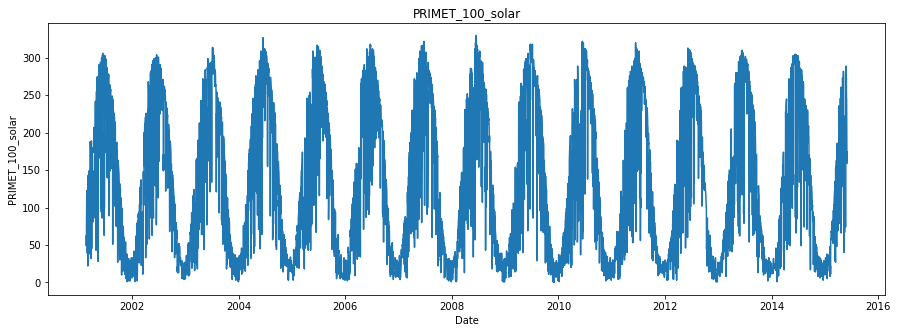

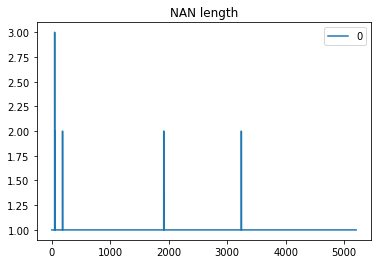

In [68]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
# if any(np.argwhere(table3[VarName] > 100)):
#      print('There are outliers > 100')


total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

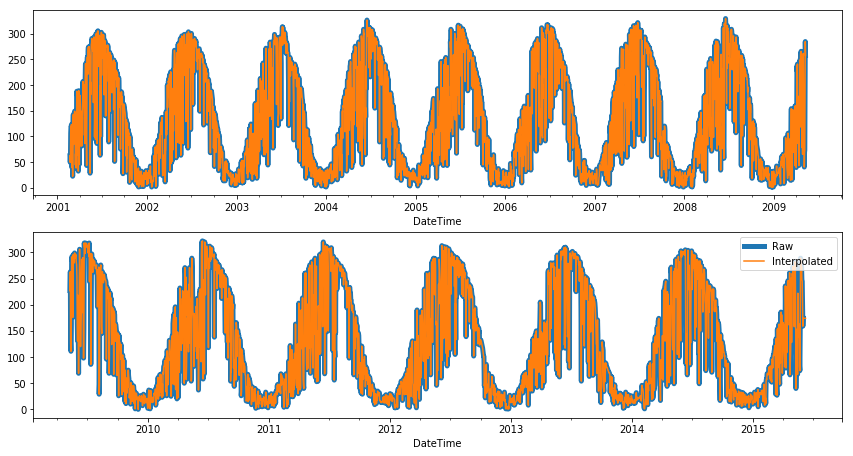

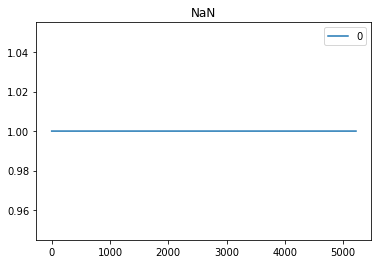

In [69]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

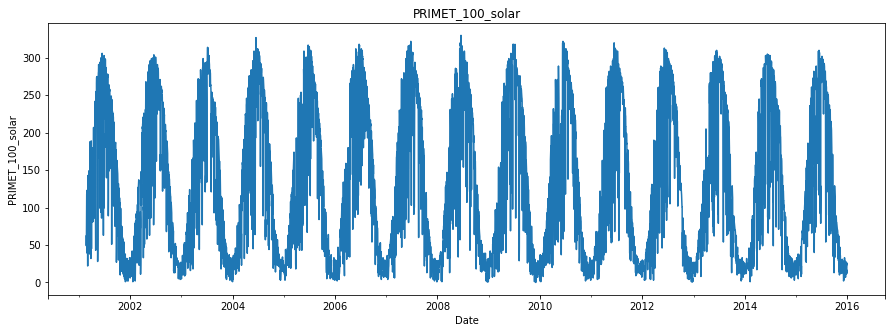

In [71]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

In [72]:
# step 5/5
# ====================================================================
# Regression against a relevant predictor variable or another station.

### DewPointTemperature


1. Are there NaN values?
2. Are they in consecutive order? If so how many are they? Find their index and subtract it.
3. Are there out of range values > threshold 1 and < threshold2

In [73]:
i = 9 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    5.2
2001-02-22    3.1
2001-02-23    3.0
2001-02-24    2.3
2001-02-25    1.9
Name: PRIMET_450_dewPointT, dtype: float64

There are missing data.


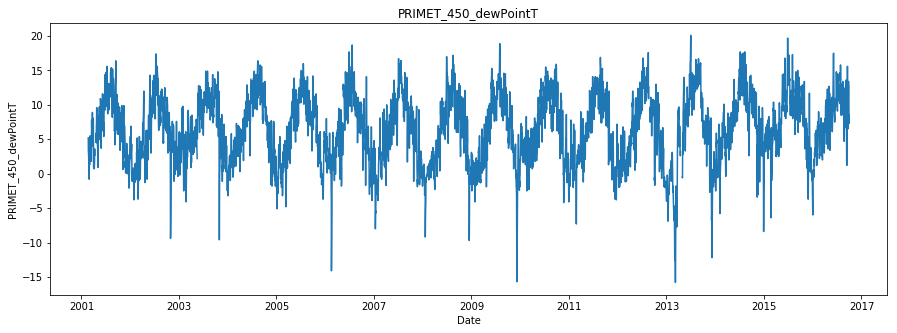

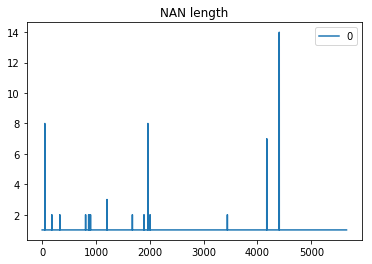

In [74]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < -25)): # negative non negative
    print('There are outliers < -25')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 25')


total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

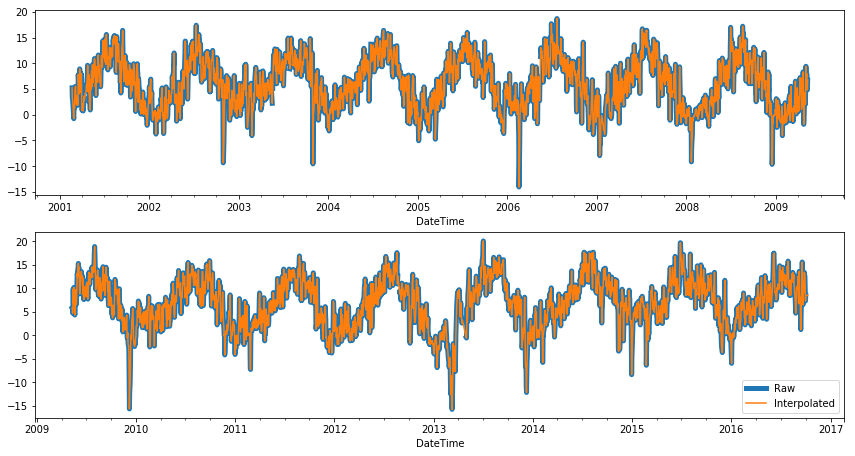

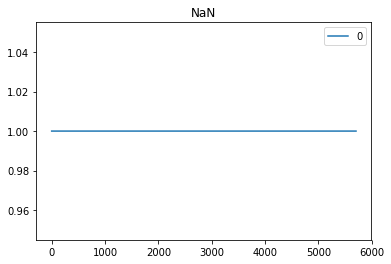

In [75]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

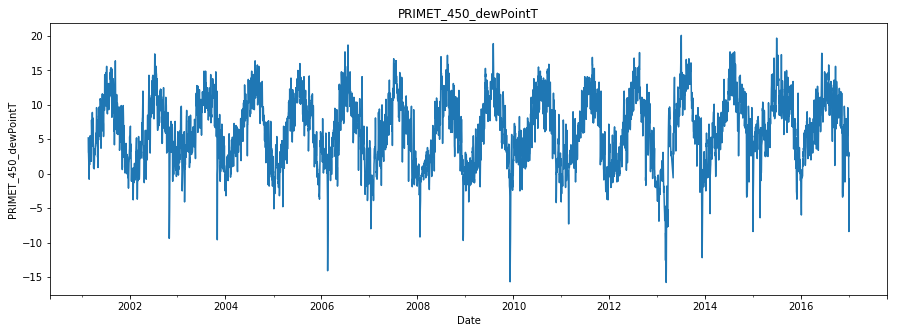

In [77]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### DewPointTemperature

1. Are there NaN values?
2. Are they in consecutive order? If so how many are they? Find their index and subtract it.
3. Are there out of range values > threshold 1 and < threshold2

In [78]:
i = 10 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    5.2
2001-02-22    3.2
2001-02-23    3.1
2001-02-24    2.4
2001-02-25    2.0
Name: PRIMET_150_dewPointT, dtype: float64

There are missing data.


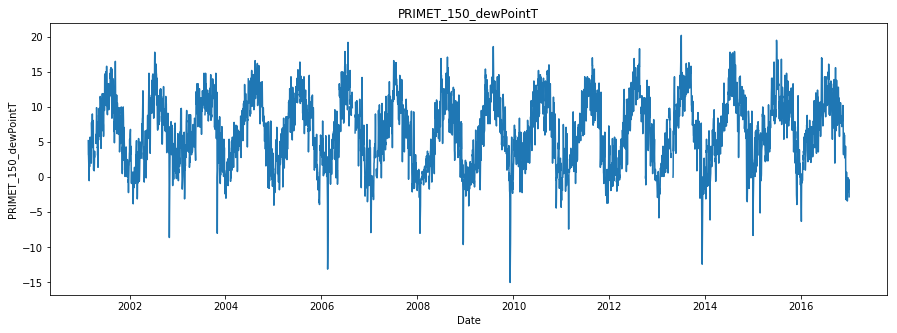

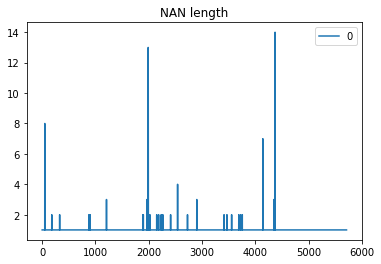

In [79]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < -25)): # negative non negative
    print('There are outliers < -25')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 25')


total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

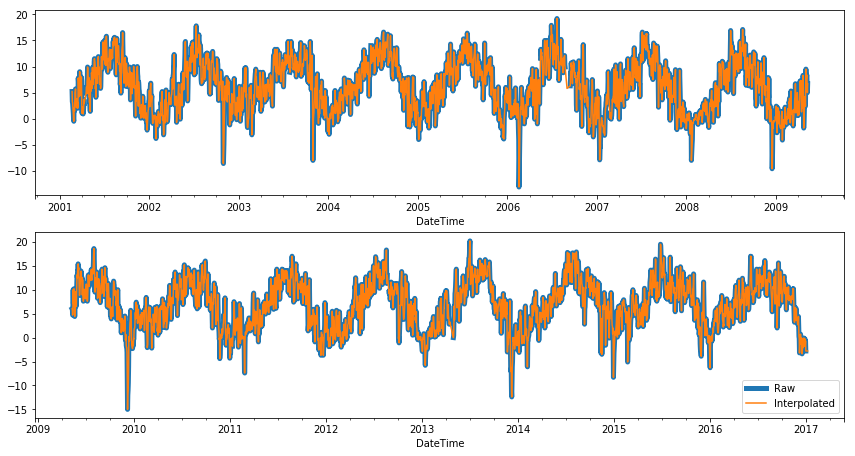

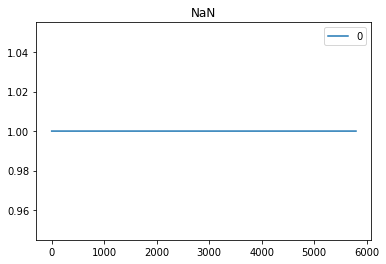

In [80]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

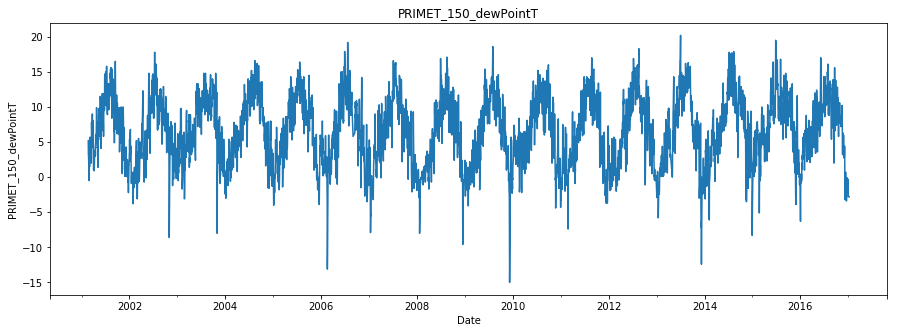

In [82]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### vaporPressure


1. Are there NaN values?
2. Are they in consecutive order? If so how many are they? Find their index and subtract it.
3. Are there out of range values > threshold 1 and < threshold2

In [83]:
i = 11 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    8.8
2001-02-22    7.6
2001-02-23    7.6
2001-02-24    7.2
2001-02-25    7.0
Name: PRIMET_450_vaporPressure, dtype: float64

There are missing data.


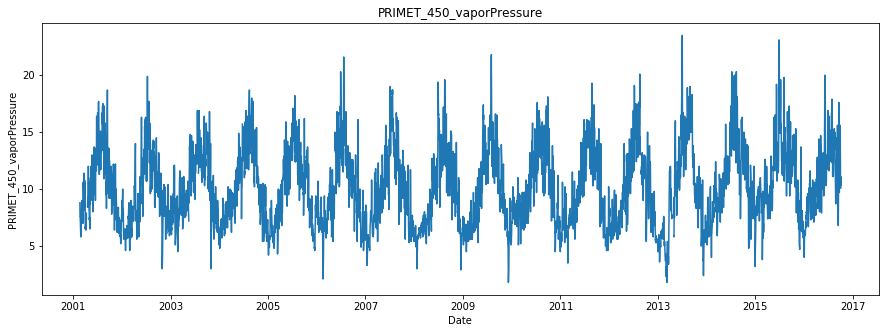

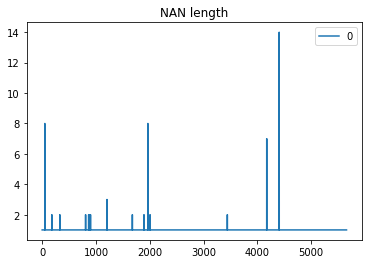

In [84]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 1000')


total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

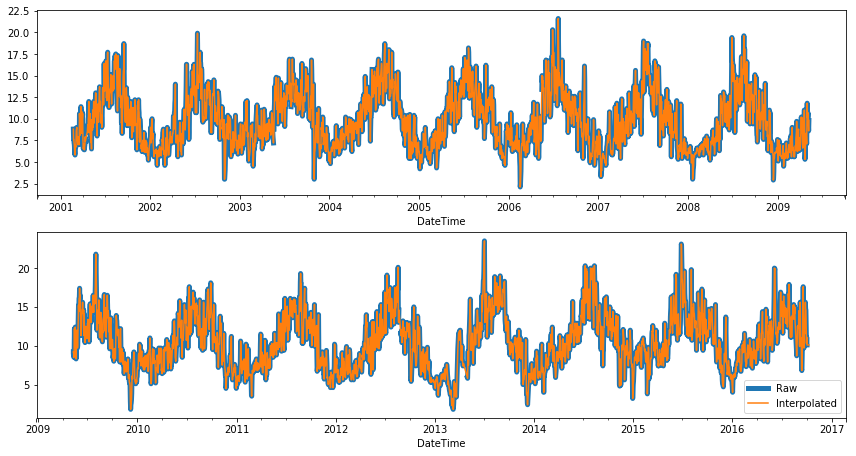

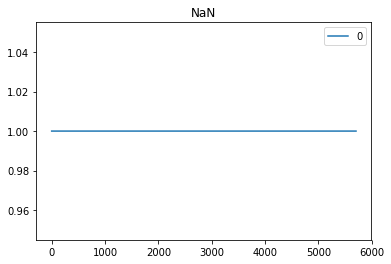

In [85]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

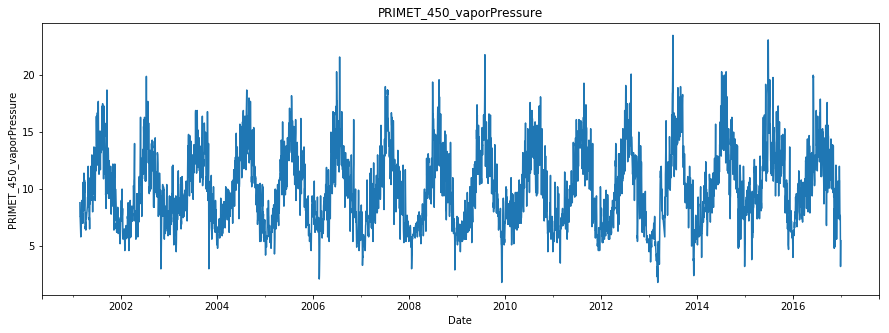

In [87]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### vaporPressure


1. Are there NaN values?
2. Are they in consecutive order? If so how many are they? Find their index and subtract it.
3. Are there out of range values > threshold 1 and < threshold2

In [88]:
i = 12 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    8.8
2001-02-22    7.7
2001-02-23    7.6
2001-02-24    7.3
2001-02-25    7.1
Name: PRIMET_150_vaporPressure, dtype: float64

There are missing data.


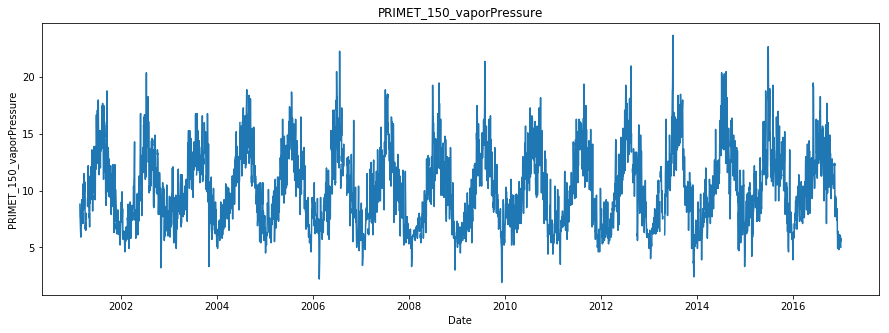

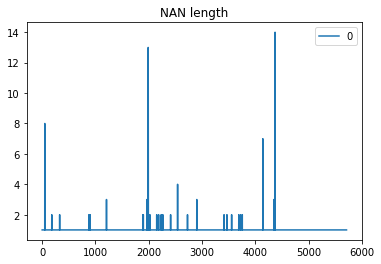

In [89]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 1000')


total length = (6158,)


Empty DataFrame
Columns: [0]
Index: []

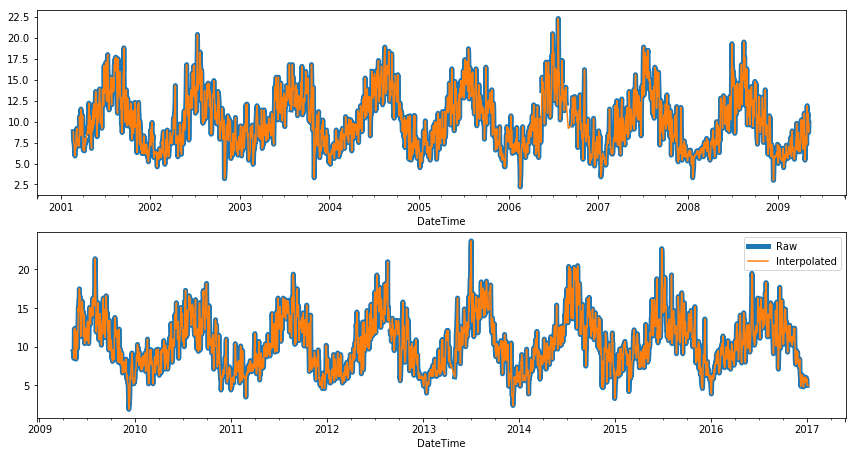

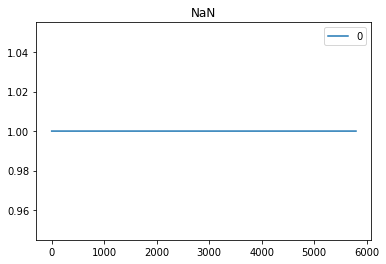

In [90]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

remainingNAN = lenNAN2[(lenNAN2.iloc[:,0]!=1)]
#y4.head(2)
print('total length =', y1.shape)
remainingNAN

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

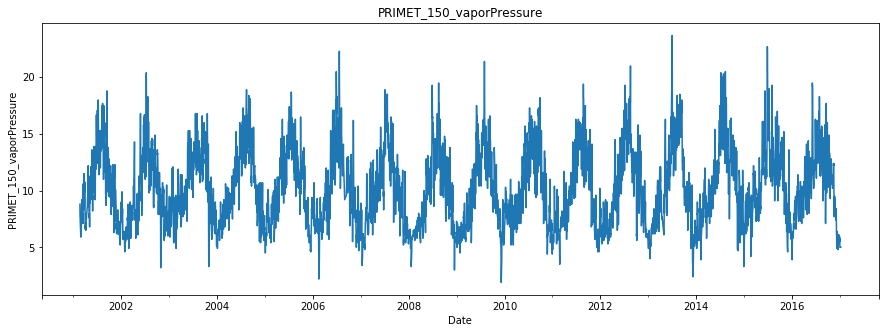

In [92]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### vaporPressureDeficit

1. Are there NaN values?
2. Are they in consecutive order? If so how many are they? Find their index and subtract it.
3. Are there out of range values > threshold 1 and < threshold2

In [93]:
i = 13 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    0.2
2001-02-22    0.3
2001-02-23    0.3
2001-02-24    0.5
2001-02-25    1.0
Name: PRIMET_450_vaporPDeficit, dtype: float64

There are missing data.


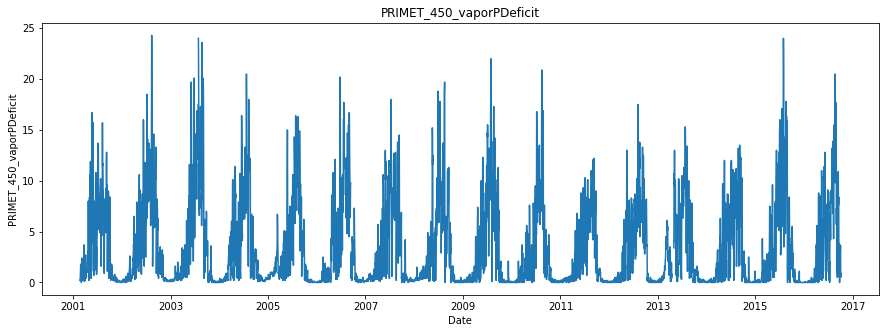

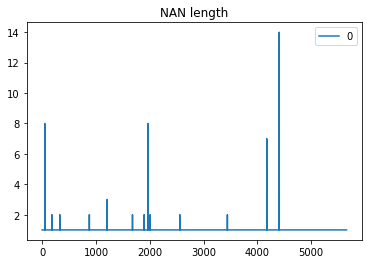

In [94]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 1000')


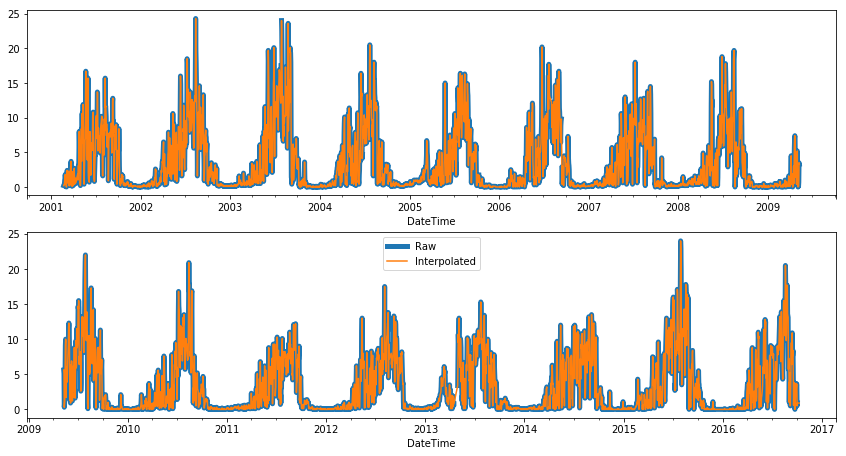

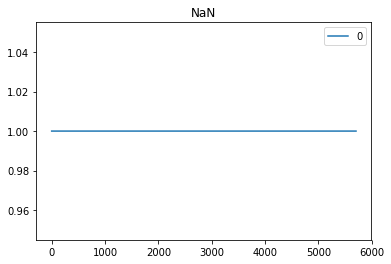

In [95]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')


In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

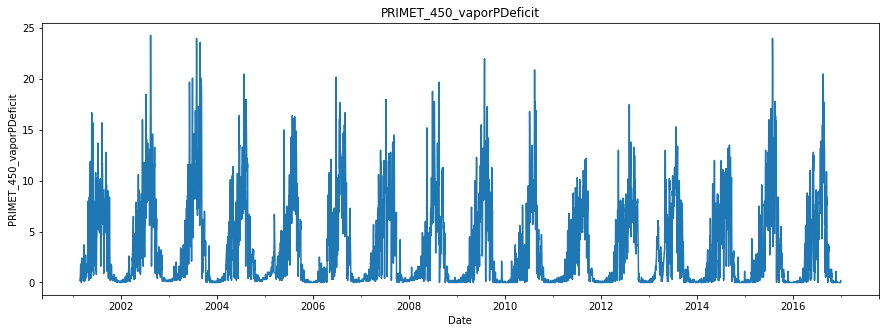

In [97]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### vaporPressureDeficit

1. Are there NaN values?
2. Are they in consecutive order? If so how many are they? Find their index and subtract it.
3. Are there out of range values > threshold 1 and < threshold2

In [98]:
i = 14 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    0.2
2001-02-22    0.3
2001-02-23    0.3
2001-02-24    0.4
2001-02-25    1.0
Name: PRIMET_150_vaporPDeficit, dtype: float64

There are missing data.


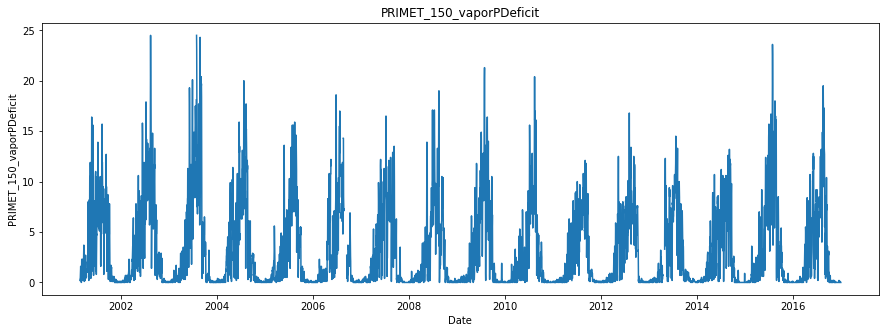

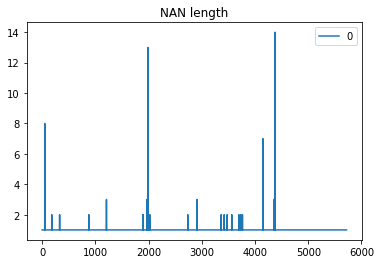

In [99]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 1000')


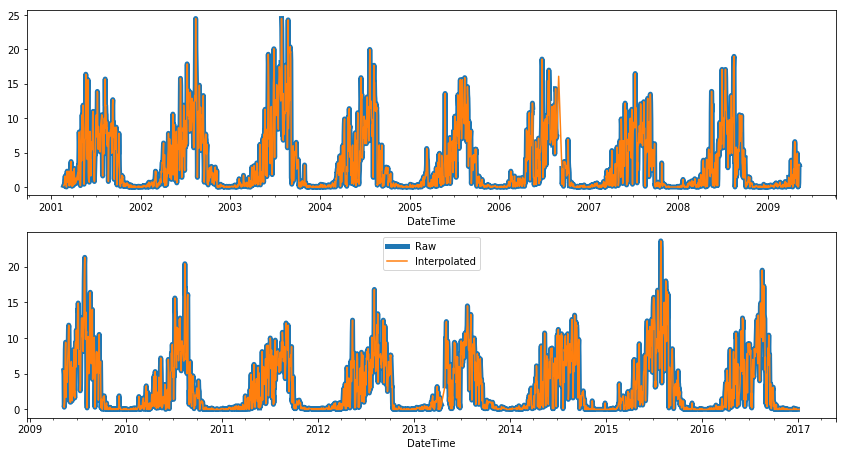

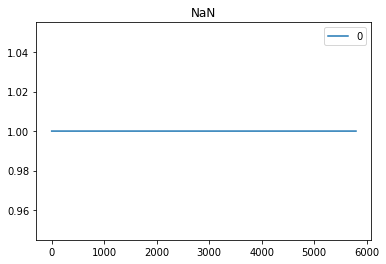

In [100]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')


In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

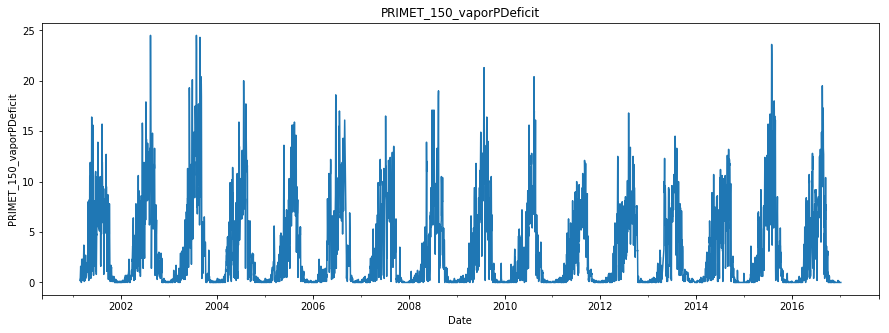

In [102]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### SoilTemperature
1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold 2

In [103]:
i = 15 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    5.3
2001-02-22    5.6
2001-02-23    6.0
2001-02-24    5.9
2001-02-25    5.9
Name: PRIMET_10_ST, dtype: float64

There are missing data.
There are outliers < 0
There are outliers > 1000


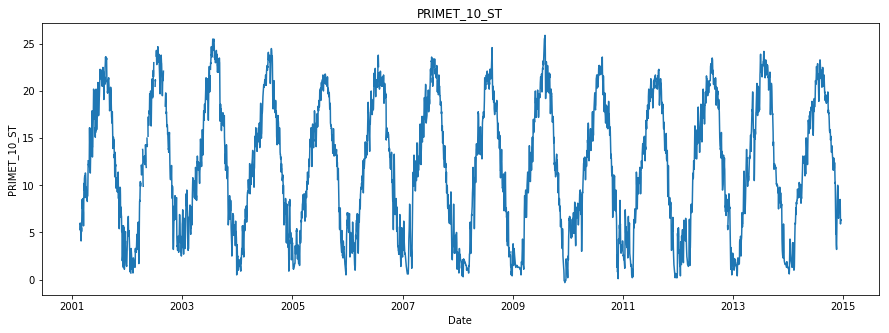

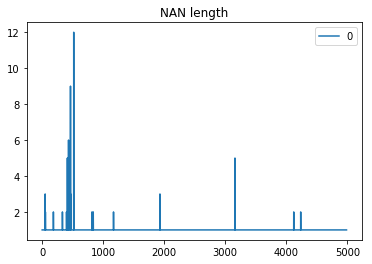

In [104]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 1000')


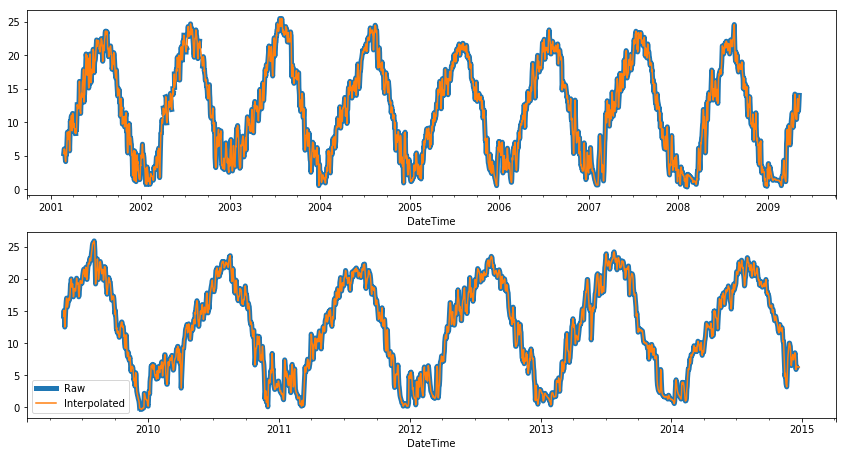

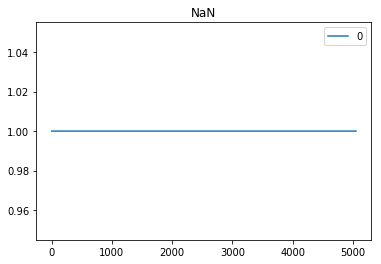

In [105]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')


In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

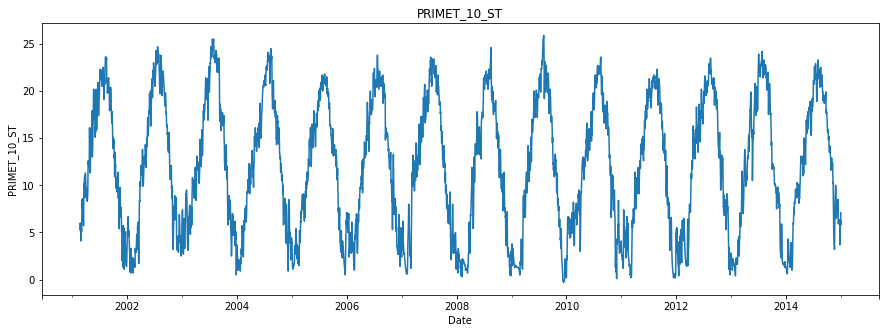

In [107]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### SoilTemperature
1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold 2

In [108]:
i = 16 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    4.9
2001-02-22    5.2
2001-02-23    5.6
2001-02-24    5.6
2001-02-25    5.7
Name: PRIMET_20_ST, dtype: float64

There are missing data.
There are outliers > 1000


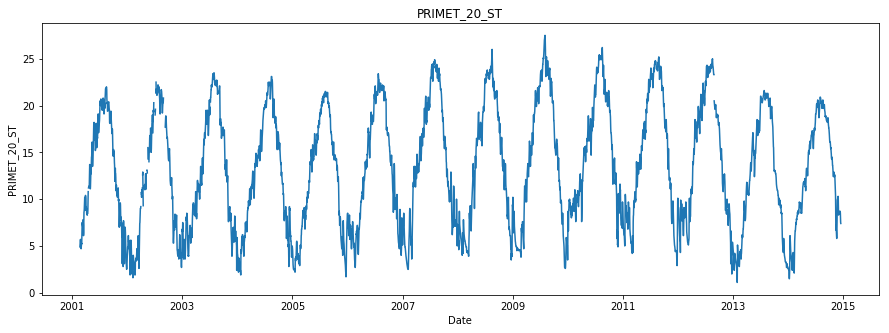

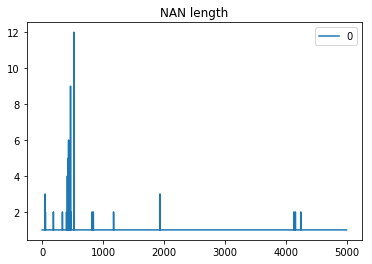

In [109]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 1000')


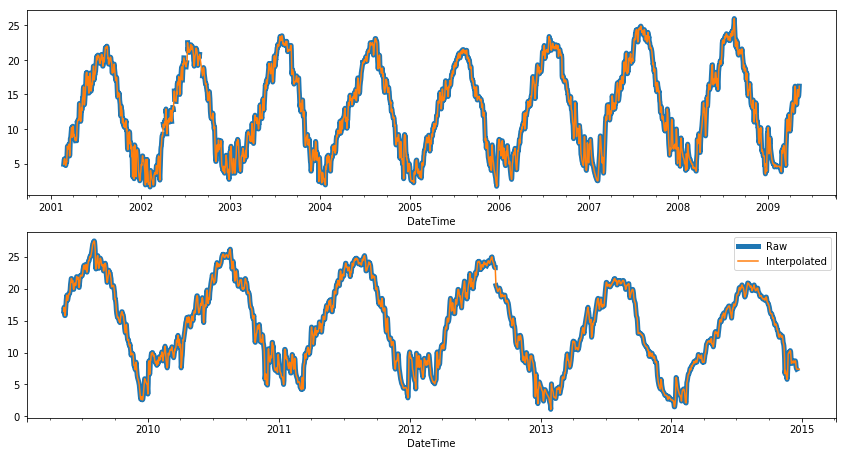

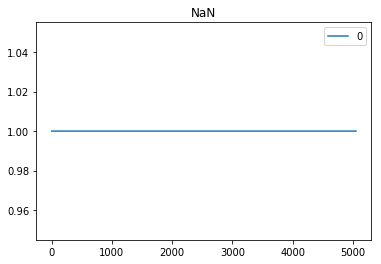

In [110]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')


In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

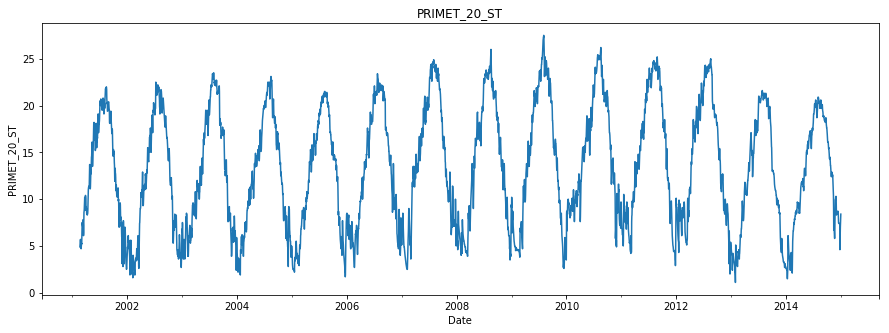

In [112]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### SoilTemperature
1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold 2

In [113]:
i = 17 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    5.0
2001-02-22    5.3
2001-02-23    5.5
2001-02-24    5.7
2001-02-25    5.8
Name: PRIMET_50_ST, dtype: float64

There are missing data.


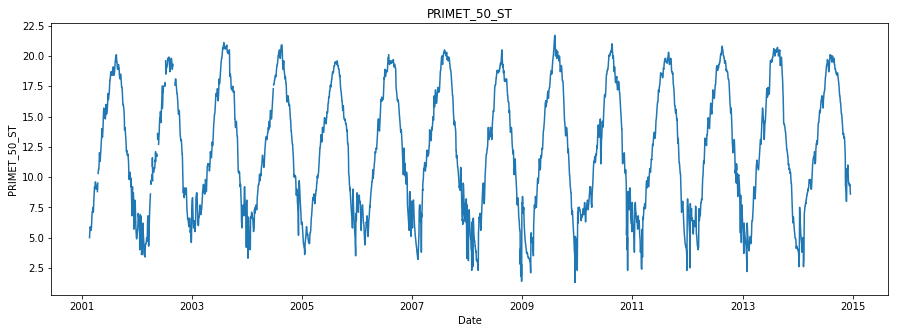

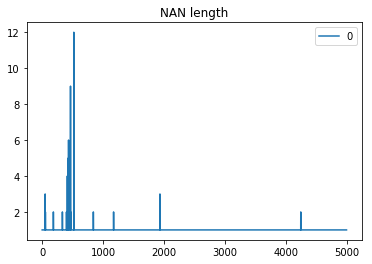

In [114]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 1000')


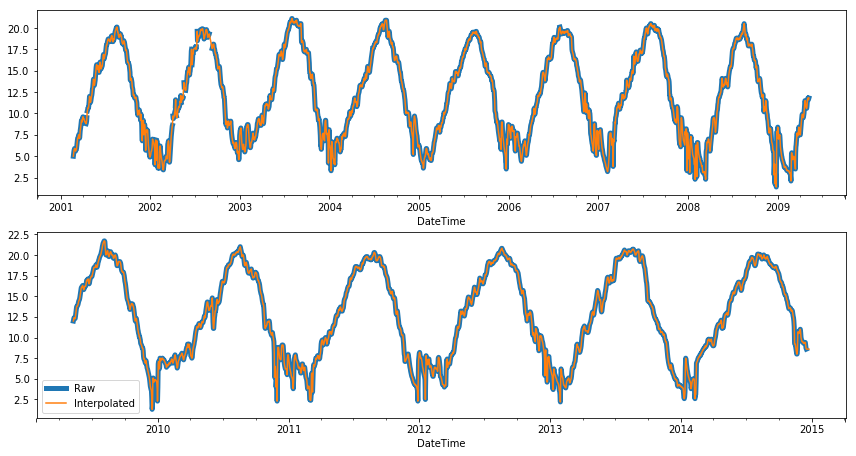

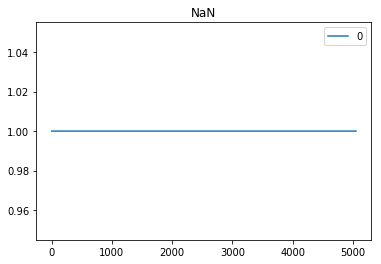

In [115]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')


In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

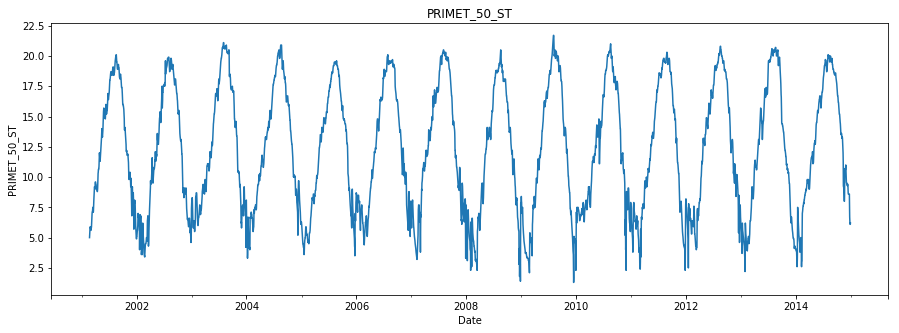

In [117]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### SoilTemperature
1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold 2

In [118]:
i = 18 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    5.8
2001-02-22    5.9
2001-02-23    6.0
2001-02-24    6.1
2001-02-25    6.1
Name: PRIMET_100_ST, dtype: float64

There are missing data.


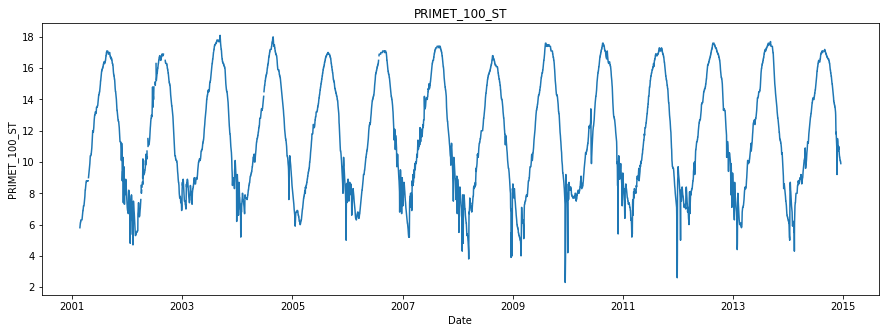

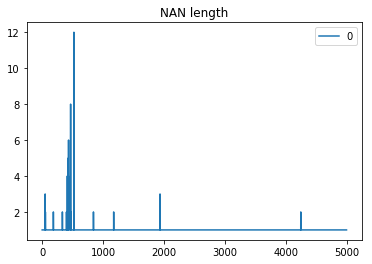

In [119]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 25)):
     print('There are outliers > 1000')


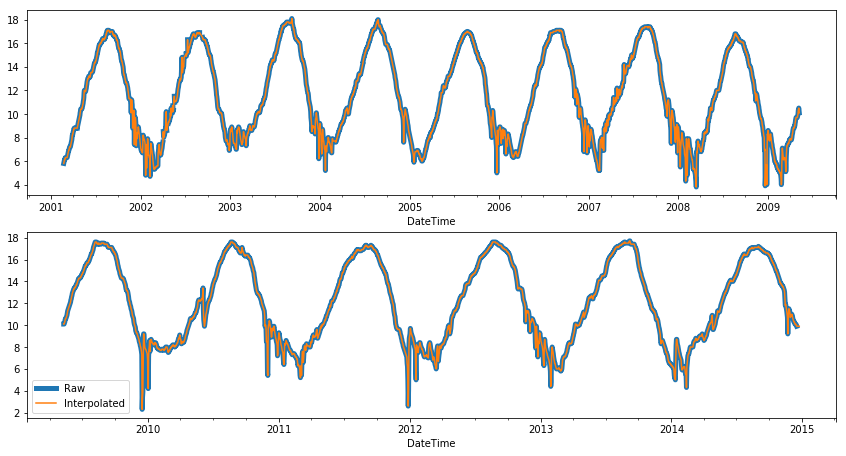

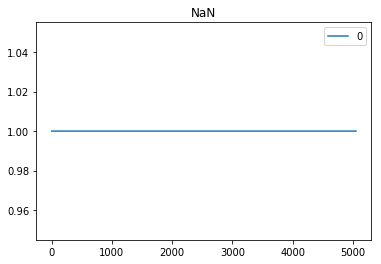

In [120]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')


In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

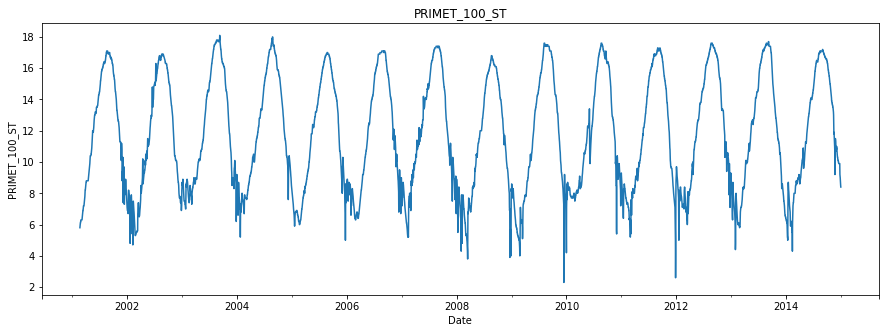

In [122]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### VolumetricMoistureContent

1. Is there any negative number?
2. Are there NaN values?
3. Are they in consecutive order? If so how many are they? Find their index and subtract it.
4. Are there out of range values > threshold 1 and < threshold2

In [123]:
i = 19 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    0.26
2001-02-22    0.25
2001-02-23    0.25
2001-02-24    0.24
2001-02-25    0.23
Name: PRIMET_10_VMC, dtype: float64

There are missing data.


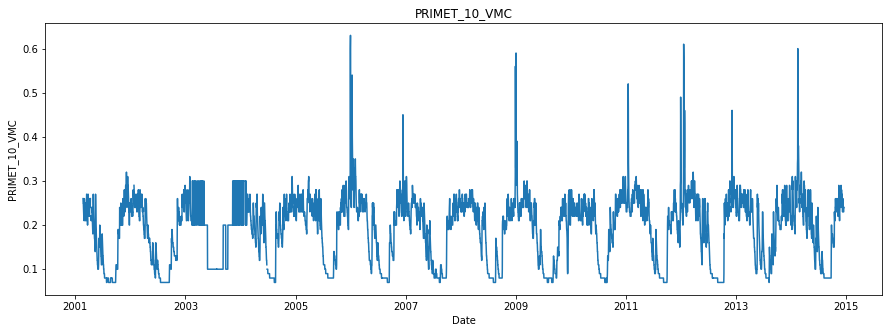

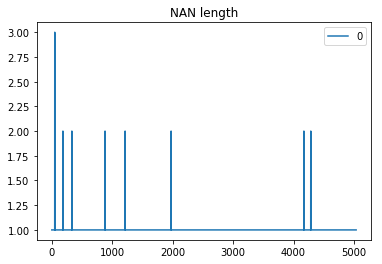

In [124]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 1)):
     print('There are outliers > 1')


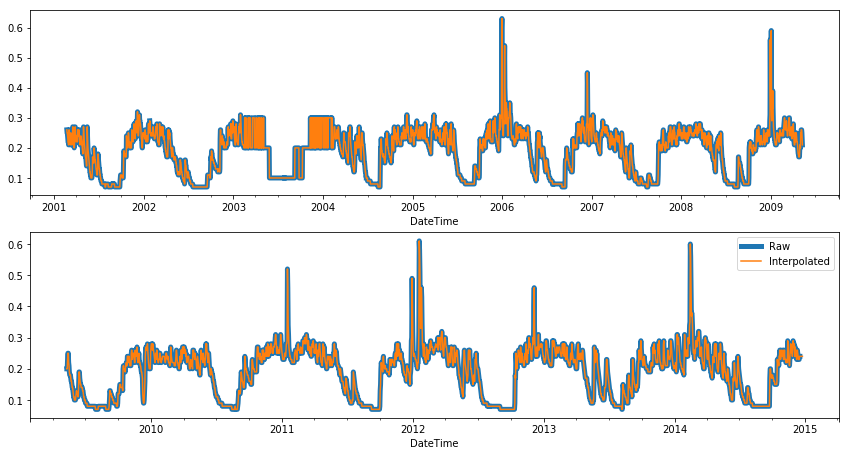

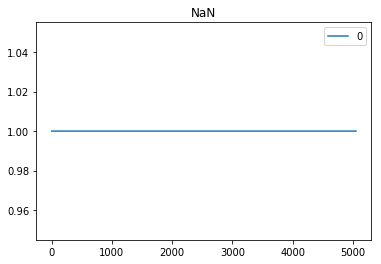

In [125]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')


In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

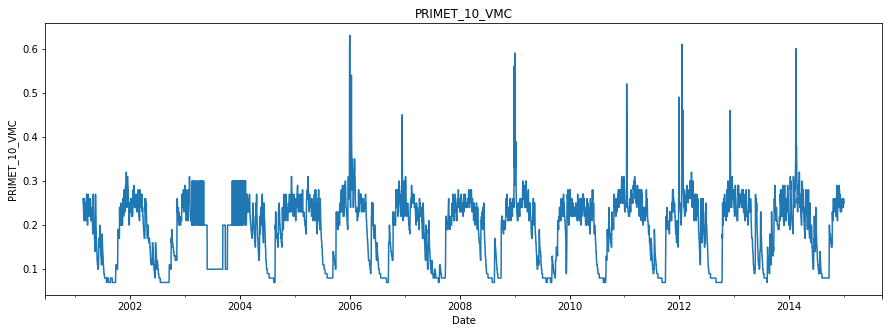

In [127]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### Volumetric Moisture Content

In [128]:
i = 20 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    0.21
2001-02-22    0.21
2001-02-23    0.20
2001-02-24    0.20
2001-02-25    0.19
Name: PRIMET_20_VMC, dtype: float64

There are missing data.


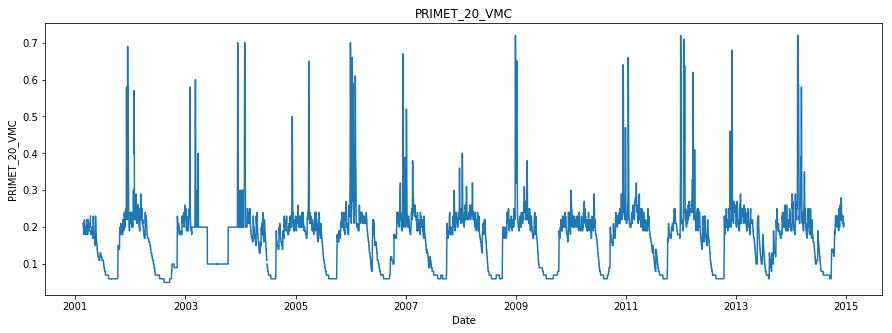

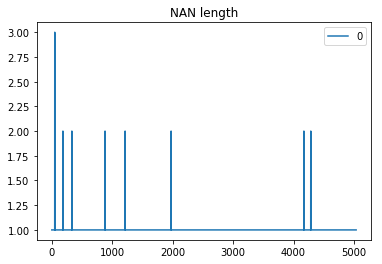

In [129]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 1)):
     print('There are outliers > 1')


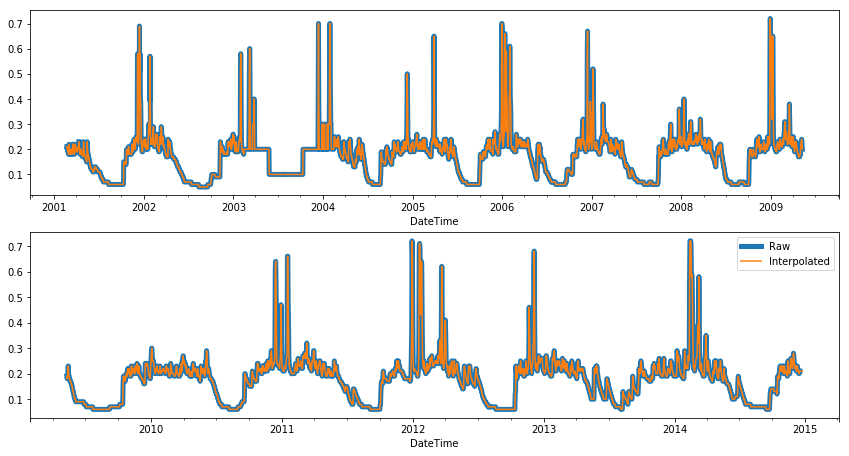

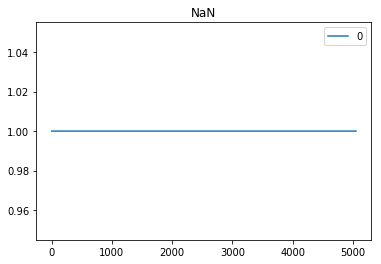

In [130]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

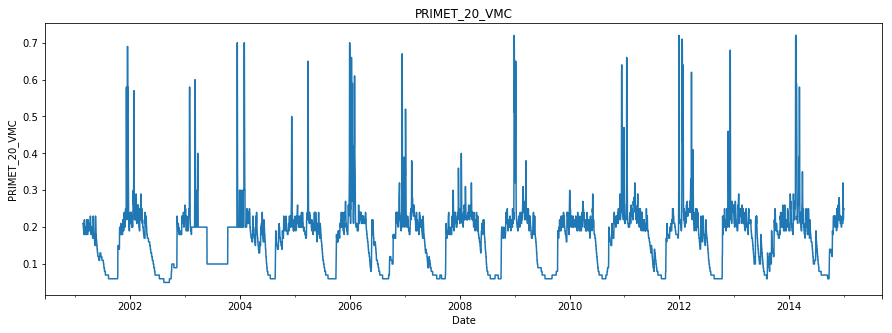

In [132]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### Volumetric Moisture Content

In [133]:
i = 21 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    0.22
2001-02-22    0.22
2001-02-23    0.22
2001-02-24    0.21
2001-02-25    0.21
Name: PRIMET_50_VMC, dtype: float64

There are missing data.


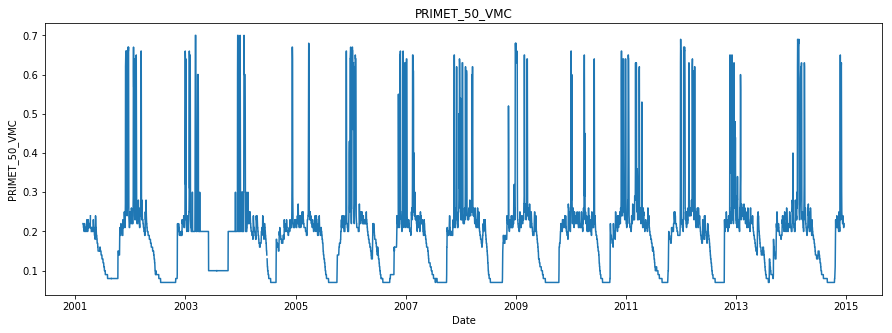

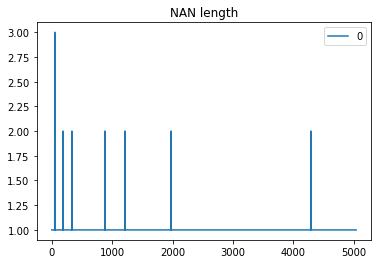

In [134]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 1)):
     print('There are outliers > 1')


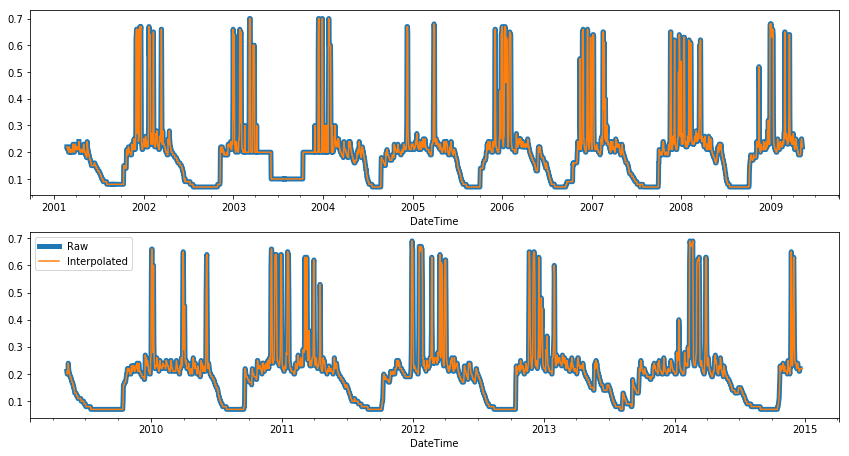

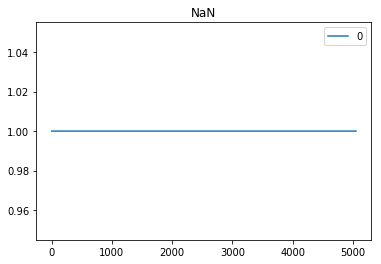

In [135]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

2001 2002 314 314 0.025723173016200522
2001 2003 314 314 0.19515896261158042
2001 2004 314 314 0.26485538397552644
2001 2005 314 314 0.09374986818993496
2001 2006 314 314 0.10283349079108421
2001 2007 314 314 0.28225128321970955
2001 2008 314 314 0.16658263216669256
2001 2009 314 314 0.18000806628787913
2001 2010 314 314 0.1759123761206703
2001 2011 314 314 0.10862128250090426
2001 2012 314 314 0.09779359297528739
2001 2013 314 314 0.30322210833823987
2001 2014 314 314 0.10715235951972239
2001 0.30322210833823987
2002 2001 314 314 0.025723173016200526
2002 2003 365 365 0.4822017028059534
2002 2004 365 365 0.5091395391339216
2002 2005 365 365 0.4611106668045791
2002 2006 365 365 0.47686397504463807
2002 2007 365 365 0.4625948873775954
2002 2008 365 365 0.6159821549227245
2002 2009 365 365 0.49471117400496867
2002 2010 365 365 0.3864826406274062
2002 2011 365 365 0.5416383290227718
2002 2012 365 365 0.6063589902561427
2002 2013 365 365 0.5203329980405027
2002 2014 358 358 0.4474192454119

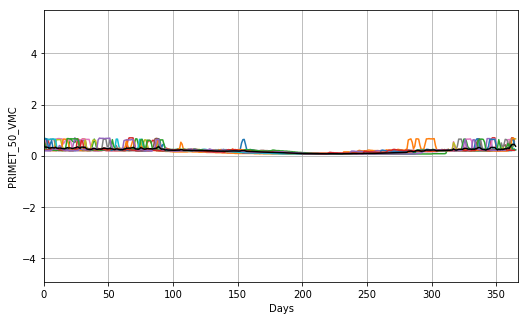

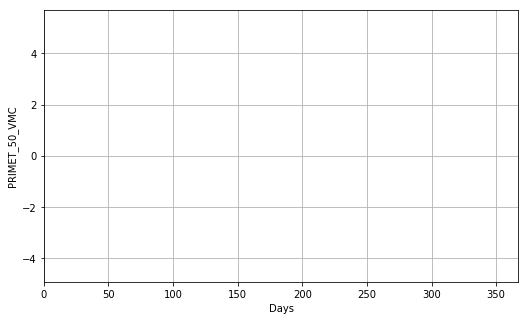

In [136]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

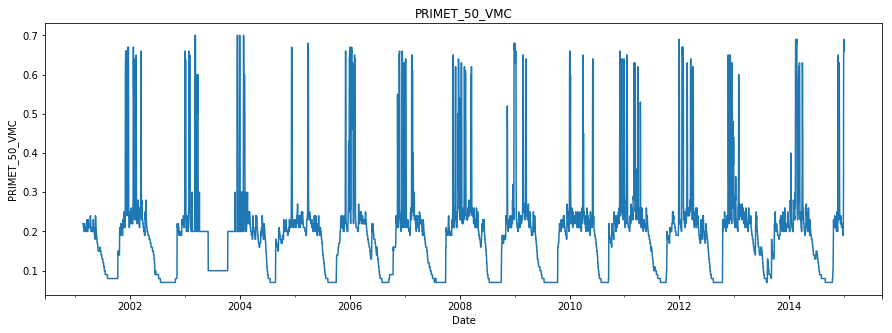

In [137]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

### Volumetric Moisture Content

In [138]:
i = 22 # column of variable being processed
VarName = table3.columns[i]
y1 = table3[VarName].copy(deep=True)
y1.head(5)

DateTime
2001-02-21    0.25
2001-02-22    0.27
2001-02-23    0.27
2001-02-24    0.27
2001-02-25    0.26
Name: PRIMET_100_VMC, dtype: float64

There are missing data.


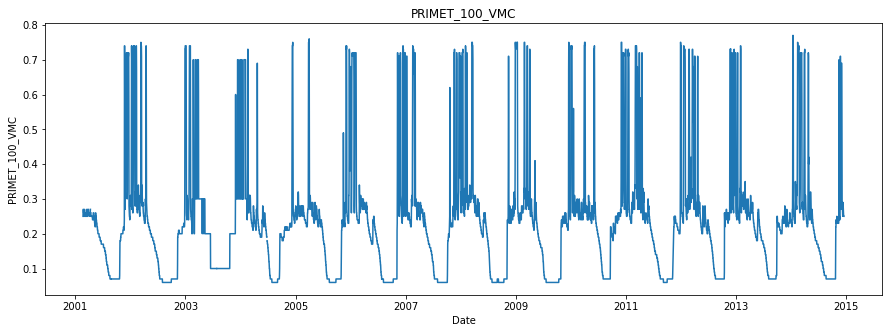

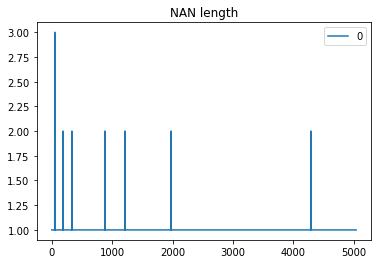

In [139]:
# step 1/5
# =====================================
# First data exploration with plots.
# Check the number of Missing values.

y1 = table3[VarName].copy(deep=True)
plt.figure(figsize=[15,5])
plt.plot(y1)
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])

ind = np.where(~np.isnan(y1)) # index where the value of y1 is not NaN
dim = np.shape(ind)[1]
if (dim!=len(y1)): # No missing data.
    print('There are missing data.')
else:
    print("No missing data.")

#===========================
# Length and location of NAN
index = np.argwhere(~np.isnan(y1)) # not nan

lenNAN = (np.diff(index,axis=0))

pd.DataFrame(lenNAN).plot(title='NAN length')
index.shape    

#Check for outlier 

#Check for outlier 
if any(np.argwhere(table3[VarName] < 0)): # negative non negative
    print('There are outliers < 0')
    
if any(np.argwhere(table3[VarName] > 1)):
     print('There are outliers > 1')


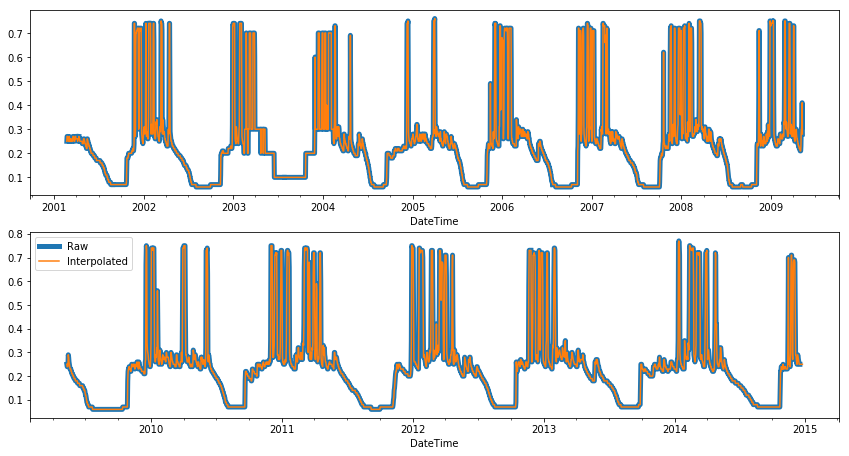

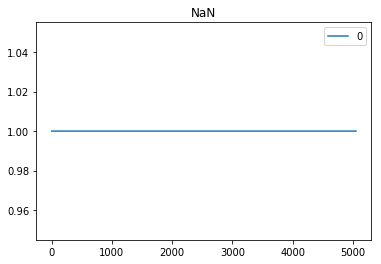

In [140]:
# step 2/5
# ============================
# Interpolation
y1 = table3[VarName].copy(deep=True)
y4 = y1.copy(deep=True)
#y4[10:40]= np.nan
y4 = y4.interpolate(limit=7, method='time',limit_direction='both') # Limit one week (1*7 = 7) for interpolation.
# 'slinear', 'spline'                                                # month 30*24 = 720

plt.subplot(211)
y1.iloc[:3000].plot(lw=5)
y4.iloc[:3000].plot()
plt.subplot(212)
y1.iloc[3000:].plot(lw=5)
y4.iloc[3000:].plot()
# y1.plot(style='*')
# y4.plot(style='.')
L=plt.legend()
L.get_texts()[0].set_text('Raw')
L.get_texts()[1].set_text('Interpolated')
fig = plt.gcf()
fig.set_size_inches(14.5, 7.5)
#fig.savefig('test2png.png', dpi=100)


#===========================================
# length of NAN
index = np.argwhere(~np.isnan(y4)) # not nan
lenNAN2 = (np.diff(index,axis=0))
lenNAN2 = pd.DataFrame(lenNAN2)
#pd.DataFrame(np.nan, index=data.index, columns=col_name)
lenNAN2.iloc[1:5,0]
lenNAN2.head(5)
lenNAN2.plot(title='NaN')

In [ ]:
# step 3/5
#===========================================
# Filling the missing data based on a similar year.
    # step 1. Consider all the years except for the Nan year. 
    # step 2. Find a similar year based on correlation coefficient. Mind how much is the correlation coefficient (>0.7)
    # step 3. Whenever the similar year has a NaN, fill the missing based on the mean N(mean of the day, std of the day)

#d99 = table3.Discharge_L_s[table3.index.year==2000].copy(deep=True)
years = range(2000, 2018, 1)
ymin= -5 + table3[VarName].min()
ymax=  5 + table3[VarName].max()
xmin=0
xmax=367

AnnualTable = np.ones([18,xmax])*np.nan # 18 years and 8785 = 24hrs*366/5days and additional two columns fpor a year.
plt.figure(1, figsize = (8.5,5))
for year in years:
    d = y4[y4.index.year==year].copy(deep=True)
    #print(d.shape[0],year)
    AnnualTable[year-2000,0] = year
    AnnualTable[year-2000,1:(d.shape[0]+1)] = d.values
    plt.plot(d.values,'-')
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    plt.ylabel(VarName)
    plt.xlabel('Days')
    plt.grid(True)
    
AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
AnnualStd = (np.nanstd(AnnualTable,axis=0))    
plt.plot(AnnualMean[1:],color='black')
AnnualTable2 = copy.deepcopy(AnnualTable)

#======================================================================================
# Calculate the year with the best/closest correlation coefficient for the nan year.
# Adopt the values from that year to the NAN values. If the closest year is nan of with corr < 0.7, go to the next non nan year.
# If this all does not work, Take the mean.

yrs = years
for yr in yrs:
    corrTable = np.ones([18,2])*np.nan # correlation coefficient table |Year| R2 |
    j = np.argwhere(AnnualTable[:,0]==yr)[0] # the row location of NAN year
    for year in years:
        if year != yr:
            k = np.argwhere(AnnualTable[:,0]==year)[0] # Potential filler year
            bad = ~np.logical_or(np.isnan(AnnualTable[j,1:xmax]), np.isnan(AnnualTable[k,1:xmax])) # NAN index in both years
            qw1 = np.compress(bad[0,:], AnnualTable[j,1:xmax]) #NAN
            qw2 = np.compress(bad[0,:], AnnualTable[k,1:xmax]) #potential
            corrTable[year-2000,0] = year
            if len(qw1)>=90 or len(qw2)>=90: # if there are more than 3 months of data per year, perform correlation.
                corrTable[year-2000,1] = np.corrcoef(qw1, qw2)[0, 1]
                print(yr,year,len(qw1),len(qw2),np.corrcoef(qw1, qw2)[0, 1])
            
    
    #=========================================
    #Fill the NAN values by the filler
    #print(yr,all(np.isnan(corrTable[:,1])))
    #if ~np.isnan(np.nanmax(corrTable[:,1]) ): # Skip filling if the entire year is nan
    if all(np.isnan(corrTable[:,1]))==False: # Skip filling if the entire year is nan
        indNAN = np.argwhere(np.isnan(AnnualTable[j,:])) # Location of nan. Wherever true, will be filled.
        indFiller = np.argwhere(corrTable[:,1]==np.nanmax(corrTable[:,1]))[0] # Filler row number
        valFiller = AnnualTable[indFiller,indNAN[:,1]]
        AnnualTable2[j,indNAN[:,1]] = valFiller # Filler value
        #==========================================
        # If any remaining, fill it with mean series
        im = np.argwhere(np.isnan(AnnualTable2[j,:])) # When both years have NaN at the same hour.
        AnnualTable2[j,im[:,1]] = AnnualMean[im[:,1]] + np.random.normal(scale=AnnualStd[im[:,1]]) # Filled with the mean value.                                                                    
        print(yr,np.nanmax(corrTable[:,1])) # year, chosen corr

# Plot the year
plt.figure(2,figsize = (8.5,5))       
plt.plot(AnnualTable2[j,1:][0],color='red')
axes = plt.gca()
axes.set_xlim([xmin,xmax])
axes.set_ylim([ymin,ymax])
plt.xlabel('Days')
plt.ylabel(VarName)
plt.grid(True)


GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2017-12-27              69.4                 NaN                 NaN   
2017-12-28              75.6                 NaN                 NaN   
2017-12-29             198.0                 NaN                 NaN   
2017-12-30             320.0                 NaN                 NaN   
2017-12-31             211.0                 NaN                 NaN   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2017-12-27                 NaN                 NaN                  NaN   
2017-12-28                 NaN                 NaN                  NaN   
2017-12-29                 NaN                 NaN                  NaN   
2017-12-30                 NaN                 NaN                  NaN   
2017-12-31                 NaN                 NaN                  NaN   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2017-12-27                  NaN                NaN               NaN   
2017-12-28                  NaN                NaN               NaN   
2017-12-29                  NaN                NaN               NaN   
2017-12-30                  NaN                NaN               NaN   
2017-12-31                  NaN                NaN               NaN   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2017-12-27                   NaN       ...                             NaN   
2017-12-28                   NaN       ...                             NaN   
2017-12-29                   NaN       ...                             NaN   
2017-12-30                   NaN       ...                             NaN   
2017-12-31                   NaN       ...                             NaN   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2017-12-27                       NaN           NaN           NaN   
2017-12-28                       NaN           NaN           NaN   
2017-12-29                       NaN           NaN           NaN   
2017-12-30                       NaN           NaN           NaN   
2017-12-31                       NaN           NaN           NaN   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2017-12-27           NaN            NaN            NaN            NaN   
2017-12-28           NaN            NaN            NaN            NaN   
2017-12-29           NaN            NaN            NaN            NaN   
2017-12-30           NaN            NaN            NaN            NaN   
2017-12-31           NaN            NaN            NaN            NaN   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2017-12-27            NaN             NaN  
2017-12-28            NaN             NaN  
2017-12-29            NaN             NaN  
2017-12-30            NaN             NaN  
2017-12-31            NaN             NaN  

[5 rows x 23 columns]

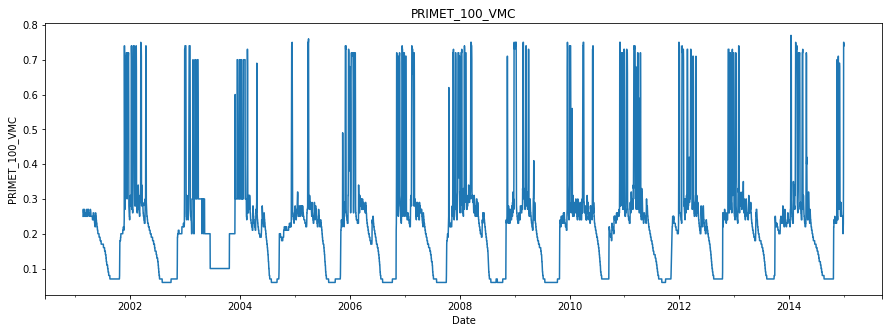

In [142]:
# step 4/5
#==================================
# Reshaping the filled data set to a vector with its time index

y5 = y4.copy(deep=True)
y5 = y5*np.nan
years = range(2000, 2018, 1)

for year in years:
    d = y5[y5.index.year==year].copy(deep=True)
    ddim = d.shape[0]
    y5.loc[d.index] = AnnualTable2[year-2000,1:(d.shape[0]+1)]

y5Temp = copy.deepcopy(y5) 

plt.figure(figsize=[15,5])
y5.plot()
plt.title(table3.columns[i])
plt.xlabel('Date')
plt.ylabel(table3.columns[i])
y5.tail(10)

TableFinal.loc[TableFinal.index,VarName] = y5Temp.loc[TableFinal.index]
TableFinal.tail(5)

In [143]:
TableFinal.head(5)

GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2001-02-21              51.0                 5.4                 5.8   
2001-02-22              53.0                 3.5                 3.9   
2001-02-23              53.0                 3.5                 3.8   
2001-02-24              52.0                 3.0                 3.3   
2001-02-25              49.0                 3.2                 3.5   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2001-02-21                 5.6                 5.6                 98.5   
2001-02-22                 3.7                 3.7                 97.1   
2001-02-23                 3.6                 3.7                 96.9   
2001-02-24                 3.1                 3.1                 95.9   
2001-02-25                 3.3                 3.2                 92.6   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2001-02-21                 98.2                8.4              62.0   
2001-02-22                 97.2                3.3              49.0   
2001-02-23                 96.9                2.8              59.0   
2001-02-24                 96.1                0.0             106.0   
2001-02-25                 93.2                0.0             118.0   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2001-02-21                   5.2       ...                             0.2   
2001-02-22                   3.1       ...                             0.3   
2001-02-23                   3.0       ...                             0.3   
2001-02-24                   2.3       ...                             0.5   
2001-02-25                   1.9       ...                             1.0   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2001-02-21                       0.2           5.3           4.9   
2001-02-22                       0.3           5.6           5.2   
2001-02-23                       0.3           6.0           5.6   
2001-02-24                       0.4           5.9           5.6   
2001-02-25                       1.0           5.9           5.7   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2001-02-21           5.0            5.8           0.26           0.21   
2001-02-22           5.3            5.9           0.25           0.21   
2001-02-23           5.5            6.0           0.25           0.20   
2001-02-24           5.7            6.1           0.24           0.20   
2001-02-25           5.8            6.1           0.23           0.19   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2001-02-21           0.22            0.25  
2001-02-22           0.22            0.27  
2001-02-23           0.22            0.27  
2001-02-24           0.21            0.27  
2001-02-25           0.21            0.26  

[5 rows x 23 columns]

In [144]:
TableFinal.to_csv('BeforeRegression_Final_table.csv', sep=',')

In [ ]:
# VMC and ST data ends at 12/31/2014
